<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Course_1B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.


# Load libraries

In [1]:
# Scikit-learn (formerly scikits.learn and also known as sklearn) is a free
# software machine learning library for the Python programming language.
# It features various classification, regression and clustering algorithms,
# and is designed to interoperate with the Python numerical and scientific
# libraries NumPy and SciPy. (from wiki)

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.inspection import permutation_importance

# common visualization module
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

# numeric library
import numpy as np

import os
import pandas as pd
from time import time as timer
import tarfile

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [3]:
pip install dtreeviz==1.4.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dtreeviz.trees import dtreeviz # remember to load the package

ModuleNotFoundError: No module named 'dtreeviz'

In [3]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

In [4]:
from utils.routines import *

# Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [11]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))

  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

true slopes: w = [4.43403411] ;  b = -4.894339520238664


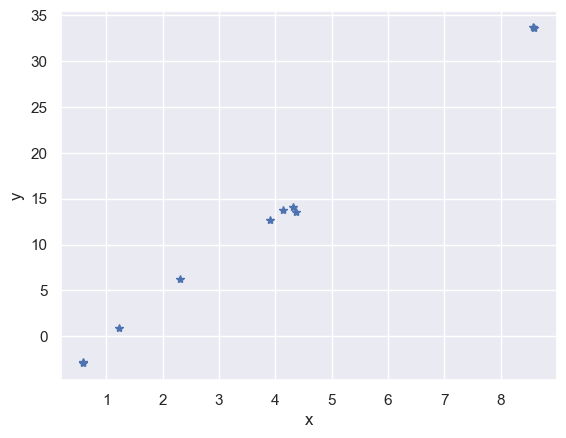

In [13]:
x, y = get_linear(n_d=1, sigma=1)
plt.plot(x[:, 0], y, '*')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

true slopes: w = [3.96323156 7.75873493] ;  b = 0.675852511629758


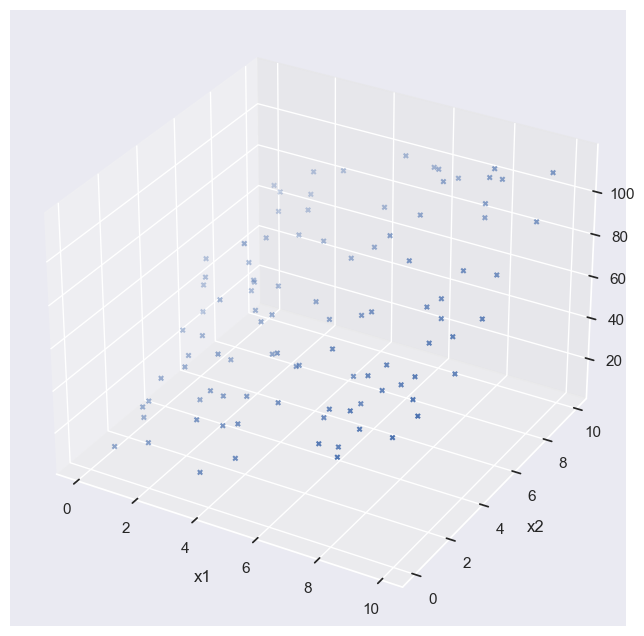

In [15]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')

plt.show()

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [17]:
def house_prices_dataset(return_df=False, return_df_xy=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False,  )

  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else ((x, y, (df_X, df_Y)) if return_df_xy else (x,y))

In [19]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

(2847, 24) (2847,)


C:\Users\vuill\AppData\Local\Temp\ipykernel_15420\3540711033.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical


Order        PID  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
0      1  526301100          20       RL        141.0    31770   Pave    NA   
1      2  526350040          20       RH         80.0    11622   Pave    NA   
2      3  526351010          20       RL         81.0    14267   Pave    NA   
3      4  526353030          20       RL         93.0    11160   Pave    NA   
4      5  527105010          60       RL         74.0    13830   Pave    NA   

  LotShape LandContour  ... PoolArea PoolQC  Fence MiscFeature MiscVal MoSold  \
0      IR1         Lvl  ...        0     NA     NA          NA       0      5   
1      Reg         Lvl  ...        0     NA  MnPrv          NA       0      6   
2      IR1         Lvl  ...        0     NA     NA        Gar2   12500      6   
3      Reg         Lvl  ...        0     NA     NA          NA       0      4   
4      IR1         Lvl  ...        0     NA  MnPrv          NA       0      3   

  YrSold SaleType  SaleCondition  SalePrice  
0   2010      WD          Normal     215000  
1   2010      WD          Normal     105000  
2   2010      WD          Normal     172000  
3   2010      WD          Normal     244000  
4   2010      WD          Normal     189900  

[5 rows x 82 columns]

In [21]:
df.describe()

Order           PID   MSSubClass  LotFrontage       LotArea  \
count  2929.000000  2.929000e+03  2929.000000  2439.000000    2929.00000   
mean   1465.461591  7.143956e+08    57.379652    69.223042   10148.06282   
std     846.104363  1.887262e+08    42.643257    23.370001    7881.35958   
min       1.000000  5.263011e+08    20.000000    21.000000    1300.00000   
25%     733.000000  5.284770e+08    20.000000    58.000000    7440.00000   
50%    1465.000000  5.354532e+08    50.000000    68.000000    9434.00000   
75%    2198.000000  9.071811e+08    70.000000    80.000000   11556.00000   
max    2930.000000  1.007100e+09   190.000000   313.000000  215245.00000   

       OverallQual  OverallCond    YearBuilt  YearRemodAdd   MasVnrArea  ...  \
count  2929.000000  2929.000000  2929.000000   2929.000000  2906.000000  ...   
mean      6.095254     5.563332  1971.344486   1984.258791   101.931865  ...   
std       1.411122     1.111678    30.243747     20.859616   179.133457  ...   
min       1.000000     1.000000  1872.000000   1950.000000     0.000000  ...   
25%       5.000000     5.000000  1954.000000   1965.000000     0.000000  ...   
50%       6.000000     5.000000  1973.000000   1993.000000     0.000000  ...   
75%       7.000000     6.000000  2001.000000   2004.000000   164.000000  ...   
max      10.000000     9.000000  2010.000000   2010.000000  1600.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  2929.000000  2929.000000    2929.000000  2929.000000  2929.000000   
mean     93.749744    47.549676      23.019461     2.593377    16.007511   
std     126.383085    67.489204      64.148601    25.145578    56.096167   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    27.000000       0.000000     0.000000     0.000000   
75%     168.000000    70.000000       0.000000     0.000000     0.000000   
max    1424.000000   742.000000    1012.000000   508.000000   576.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  2929.000000   2929.000000  2929.000000  2929.000000    2929.000000  
mean      2.244111     50.652441     6.216456  2007.790372  180800.599522  
std      35.603235    566.440219     2.714863     1.316832   79899.955086  
min       0.000000      0.000000     1.000000  2006.000000   12789.000000  
25%       0.000000      0.000000     4.000000  2007.000000  129500.000000  
50%       0.000000      0.000000     6.000000  2008.000000  160000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  213500.000000  
max     800.000000  17000.000000    12.000000  2010.000000  755000.000000  

[8 rows x 39 columns]

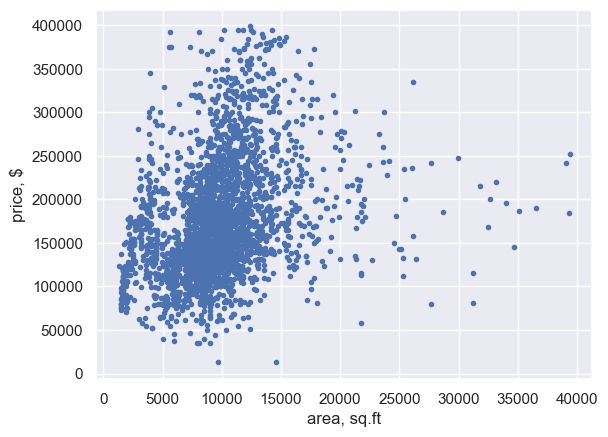

In [23]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');
plt.show()

## 3. Blobs

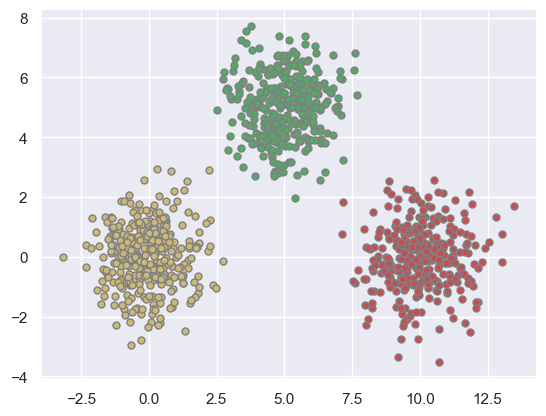

In [25]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()

In [27]:
print(x), print(y)

[[ 0.63288484 -0.03019142]
 [10.28278923 -0.6484879 ]
 [ 9.09855695  1.03171471]
 ...
 [ 9.71363636  0.32844781]
 [-0.17948651 -0.17612112]
 [ 5.45848575  5.4729279 ]]
[0 2 2 2 1 0 0 2 1 0 1 0 0 0 1 2 1 1 0 2 0 1 1 1 0 0 1 0 2 2 2 0 2 2 2 2 1
 2 1 1 0 0 2 1 1 0 0 2 1 1 2 2 0 2 1 1 1 1 2 1 1 0 1 1 2 0 2 2 1 0 2 2 2 1
 2 0 2 2 1 2 1 1 1 1 0 2 1 1 1 2 0 0 0 1 2 1 1 2 1 1 1 0 0 2 1 2 0 0 0 1 1
 2 1 2 1 0 0 1 1 2 1 2 1 1 2 2 0 0 0 1 2 2 2 2 0 0 0 1 1 2 0 2 0 1 2 0 1 2
 1 1 0 1 1 1 2 1 1 0 1 0 1 1 1 1 2 1 2 1 1 0 1 0 1 2 0 2 0 2 1 0 1 2 0 2 0
 2 2 0 1 2 2 2 0 1 0 0 0 0 0 0 0 2 0 0 2 1 2 2 2 0 1 2 0 1 2 2 0 2 2 2 0 1
 2 0 2 1 0 0 0 0 2 2 1 1 1 0 1 2 2 2 0 2 2 2 2 2 1 2 2 2 1 0 0 0 0 0 1 2 0
 1 2 0 2 0 1 0 2 1 0 1 1 2 0 2 2 1 1 0 1 1 2 1 0 1 2 2 0 2 0 1 0 1 1 1 0 0
 2 0 0 0 1 2 0 2 1 2 1 0 2 0 0 1 0 0 0 0 1 0 0 1 0 1 2 0 0 1 0 0 1 1 2 1 2
 1 0 2 0 1 1 0 0 0 0 0 0 2 1 2 1 1 2 2 0 2 2 0 0 0 0 0 2 1 1 1 2 1 2 1 2 2
 0 0 2 0 1 0 1 2 1 2 0 1 1 1 0 1 0 0 0 0 0 1 2 0 2 0 2 0 1 2 0 2 2 0 0 0 2
 1 0 2 

(None, None)

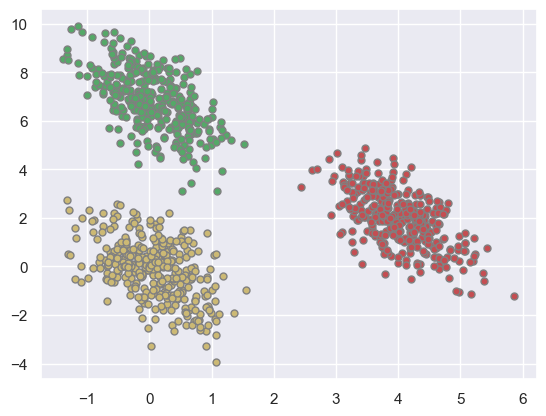

In [29]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])

transformation = [[0.4, 0.2], [-0.4, 1.2]]  # affine transformation matrix
x = np.dot(x, transformation)               # applied to point coordinated to make blobs less separable

colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()



## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [109]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Let's check few samples:

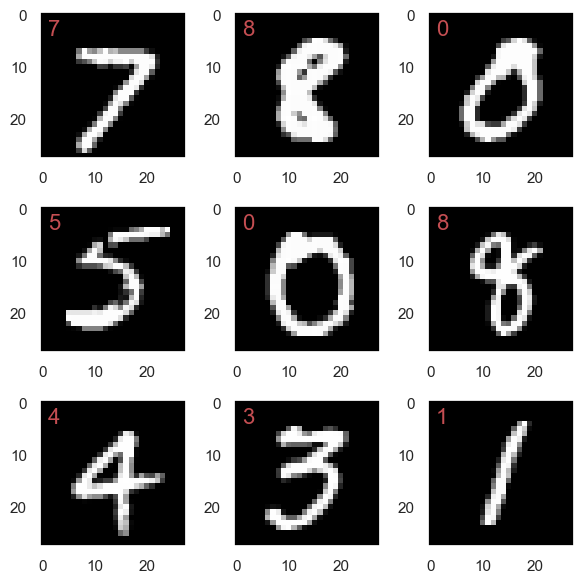

In [111]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()
plt.show()

## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [113]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Let's check few samples:

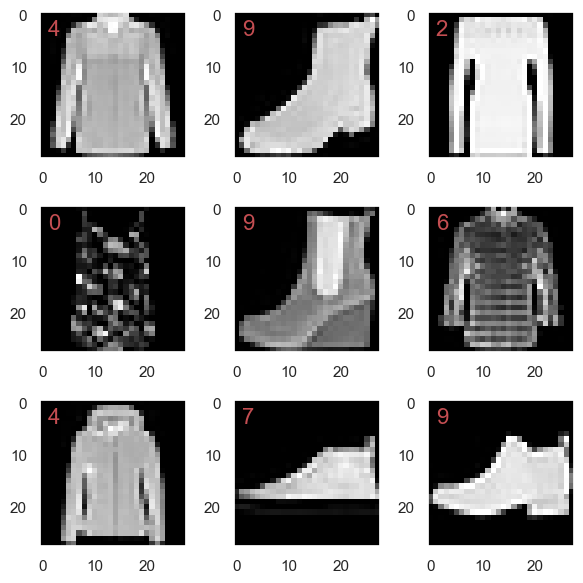

In [37]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()
plt.show()

In [39]:
fmnist_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

# 2. Trees & Forests

## 1. Decision Tree

Decision Trees are a supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning **simple** decision rules inferred from the data features.

They are fast to train, easily interpretable, capture non-linear dependencies, and require small amount of data.

We will see that each tree creates a partition of the feature space $X$ into subregions $R_i,i=1..N_r$, this partition being described by a tree structure. Predictions will be made with the following procedure. Given a new test point $x$:

1. Assign $x$ to the region it belongs, e.g. $R_k$
2. For classification, make a majiority vote using the training points belonging to $R_k$. For regression, evaluate the mean of the target over all training points belonging to $R_k$.

Let's see how the trees generate a partition of the domain into distinct regions.


In [41]:
# routine for coloring 2d space according to class prediction

def plot_prediction_2d(x_min, x_max, y_min, y_max, classifier, ax=None):
  """
  Creates 2D mesh, predicts class for each point on the mesh, and visualises it
  """

  mesh_step = .02  # step size in the mesh
  x_coords = np.arange(x_min, x_max, mesh_step) # coordinates of mesh colums
  y_coords = np.arange(y_min, y_max, mesh_step) # coordinates of mesh rows

  # create mesh, and get x and y coordinates of each point point
  # arrenged as array of shape (n_mesh_rows, n_mesh_cols)
  mesh_nodes_x, mesh_nodes_y = np.meshgrid(x_coords, y_coords)

  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, x_max]x[y_min, y_max].

  # prepare xy pairs for prediction: matrix of size (n_mesh_rows*n_mesh_cols, 2)
  mesh_xy_coords = np.stack([mesh_nodes_x.flatten(),
                             mesh_nodes_y.flatten()], axis=-1)

  # obtain class for each node
  mesh_nodes_class = classifier.predict(mesh_xy_coords)


  # reshape to the shape (n_mesh_rows, n_mesh_cols)==mesh_nodes_x.shape for visualization
  mesh_nodes_class = mesh_nodes_class.reshape(mesh_nodes_x.shape)

  # Put the result into a color countour plot
  ax = ax or plt.gca()
  ax.contourf(mesh_nodes_x,
              mesh_nodes_y,
              mesh_nodes_class,
              cmap='Pastel1', alpha=0.5)

training score : 0.667 (depth=1)


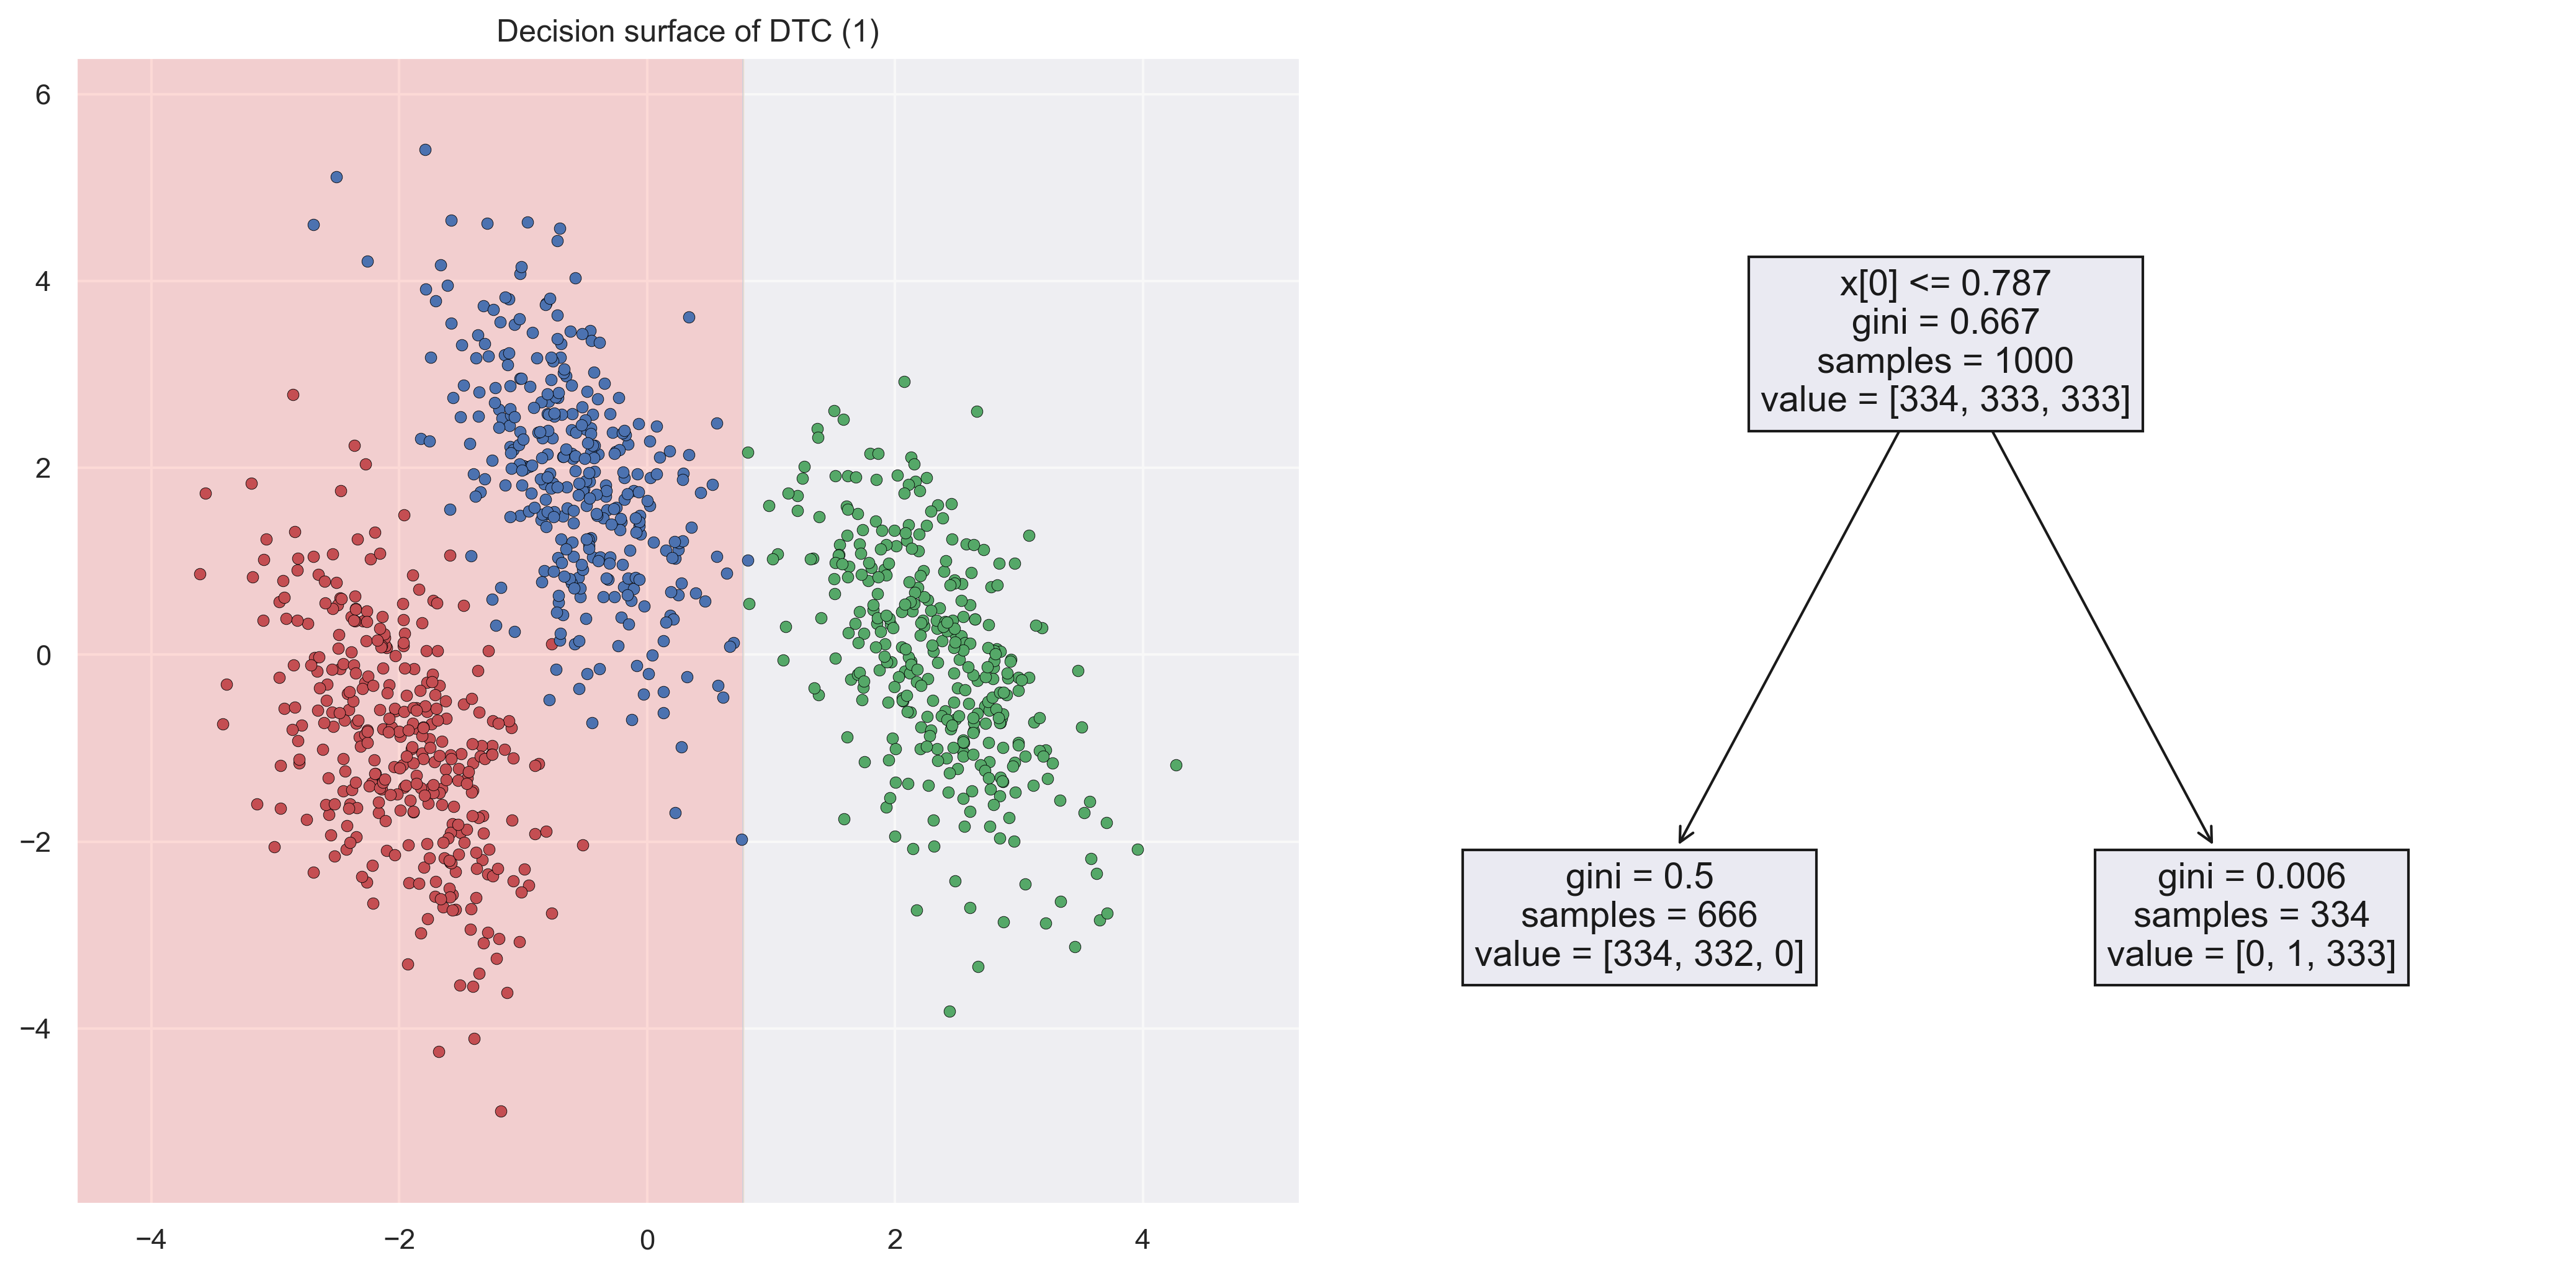

training score : 0.942 (depth=2)


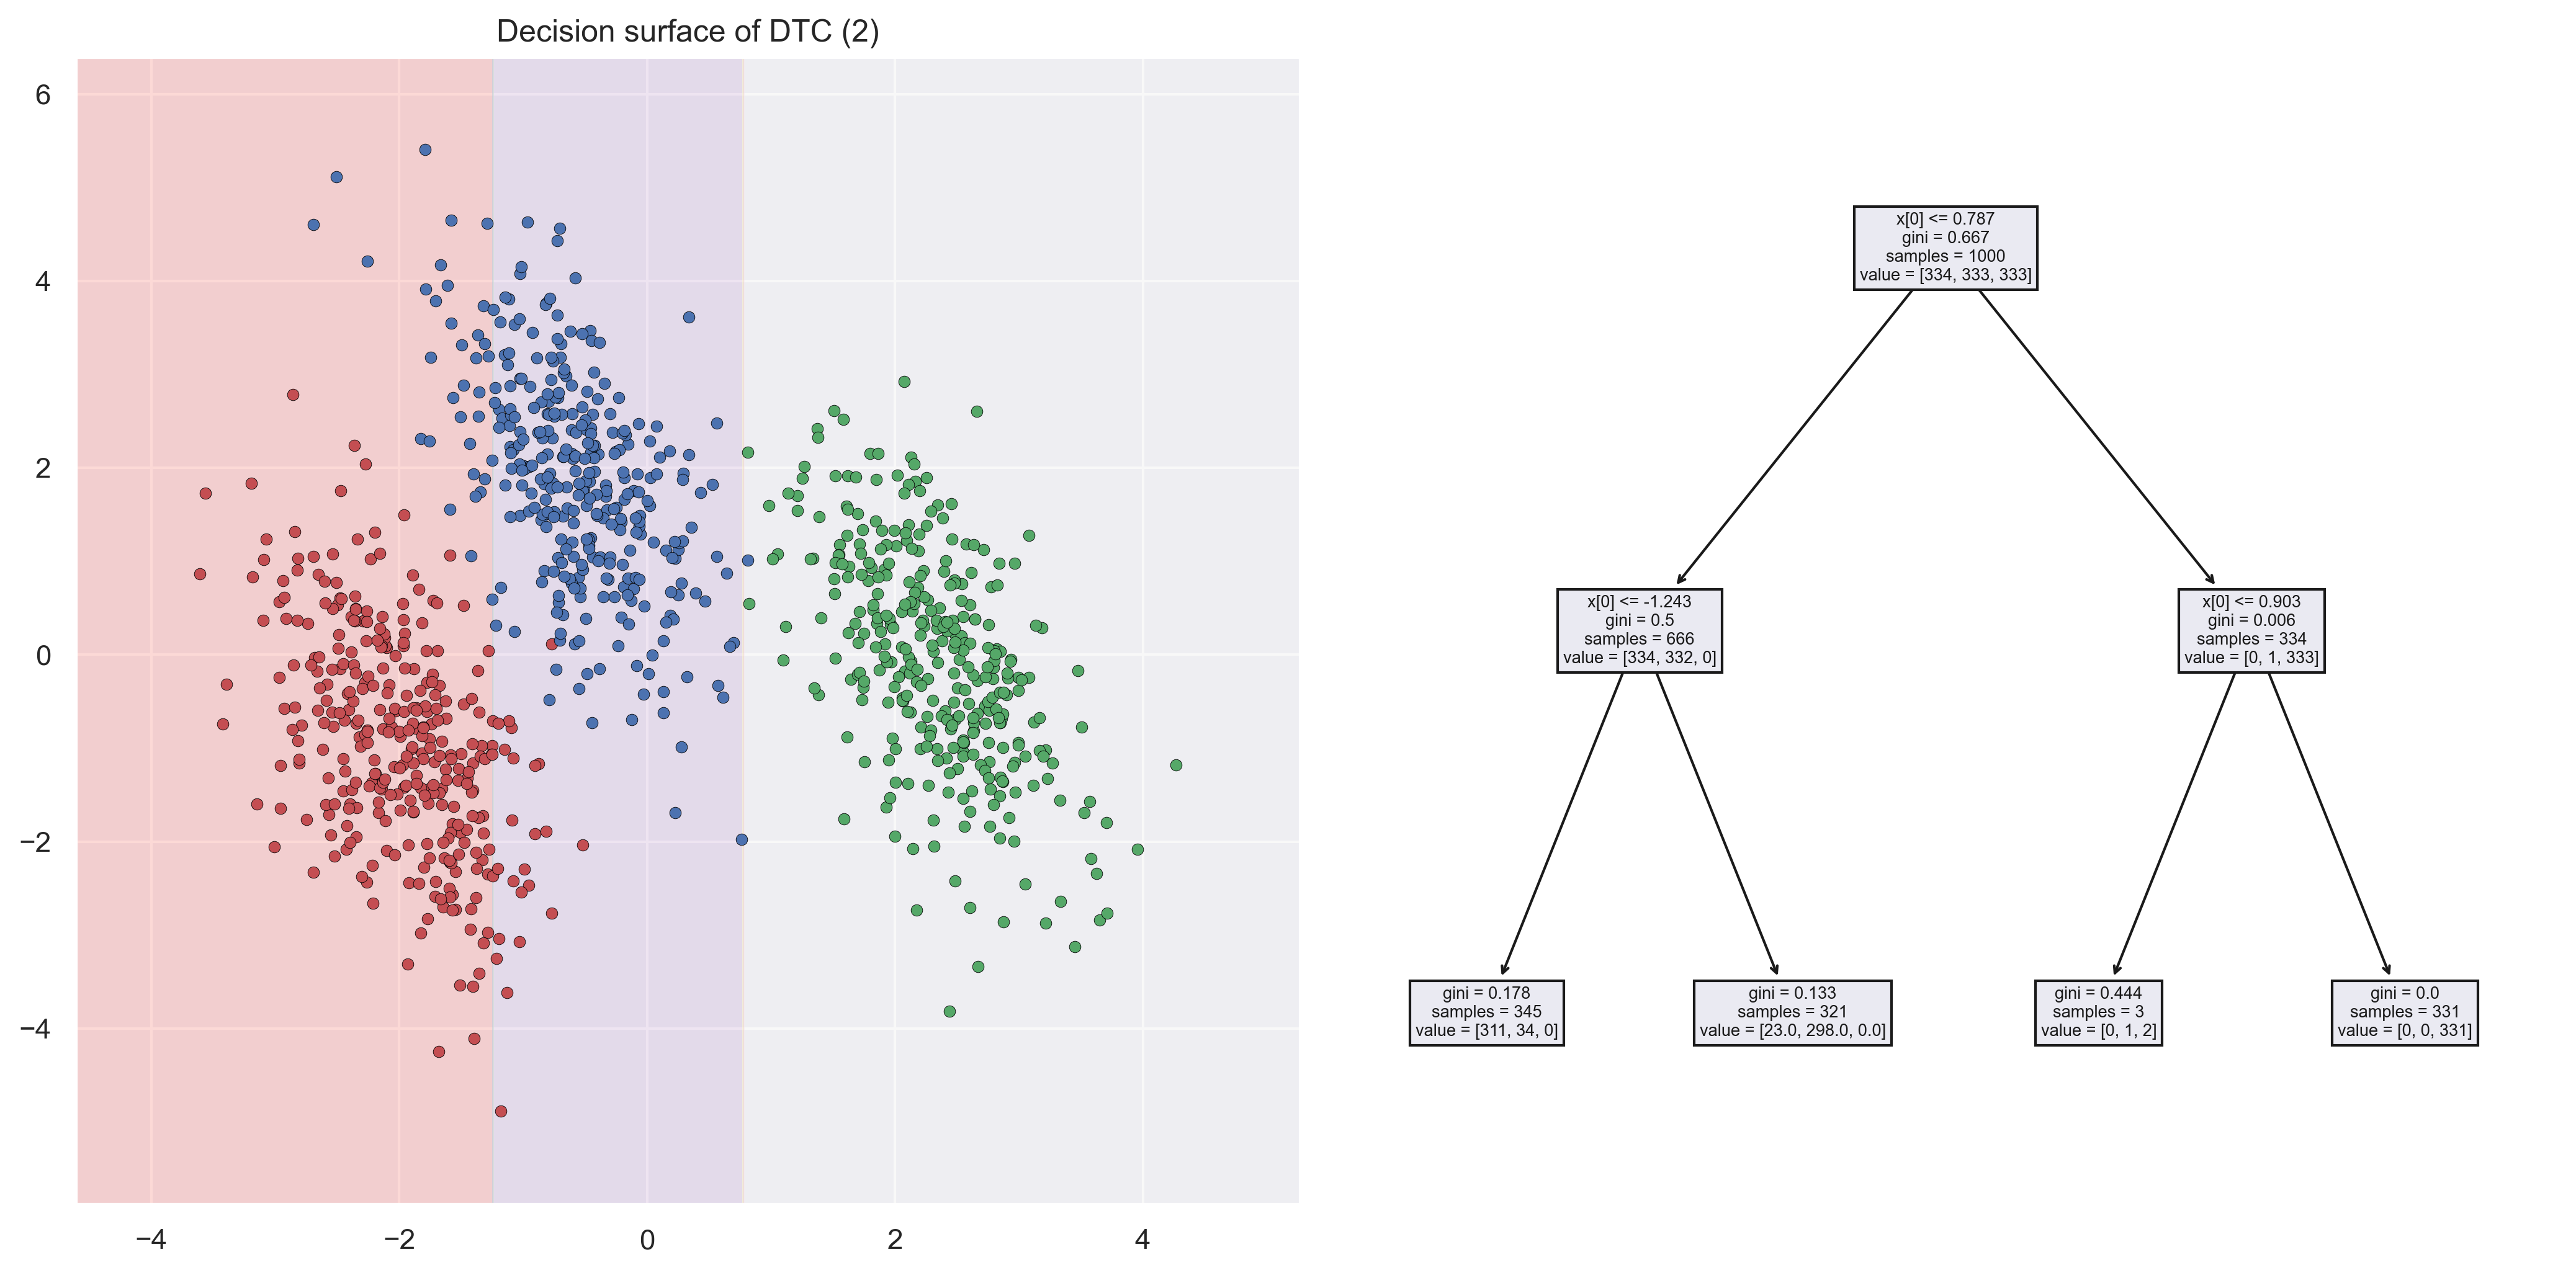

training score : 0.986 (depth=3)


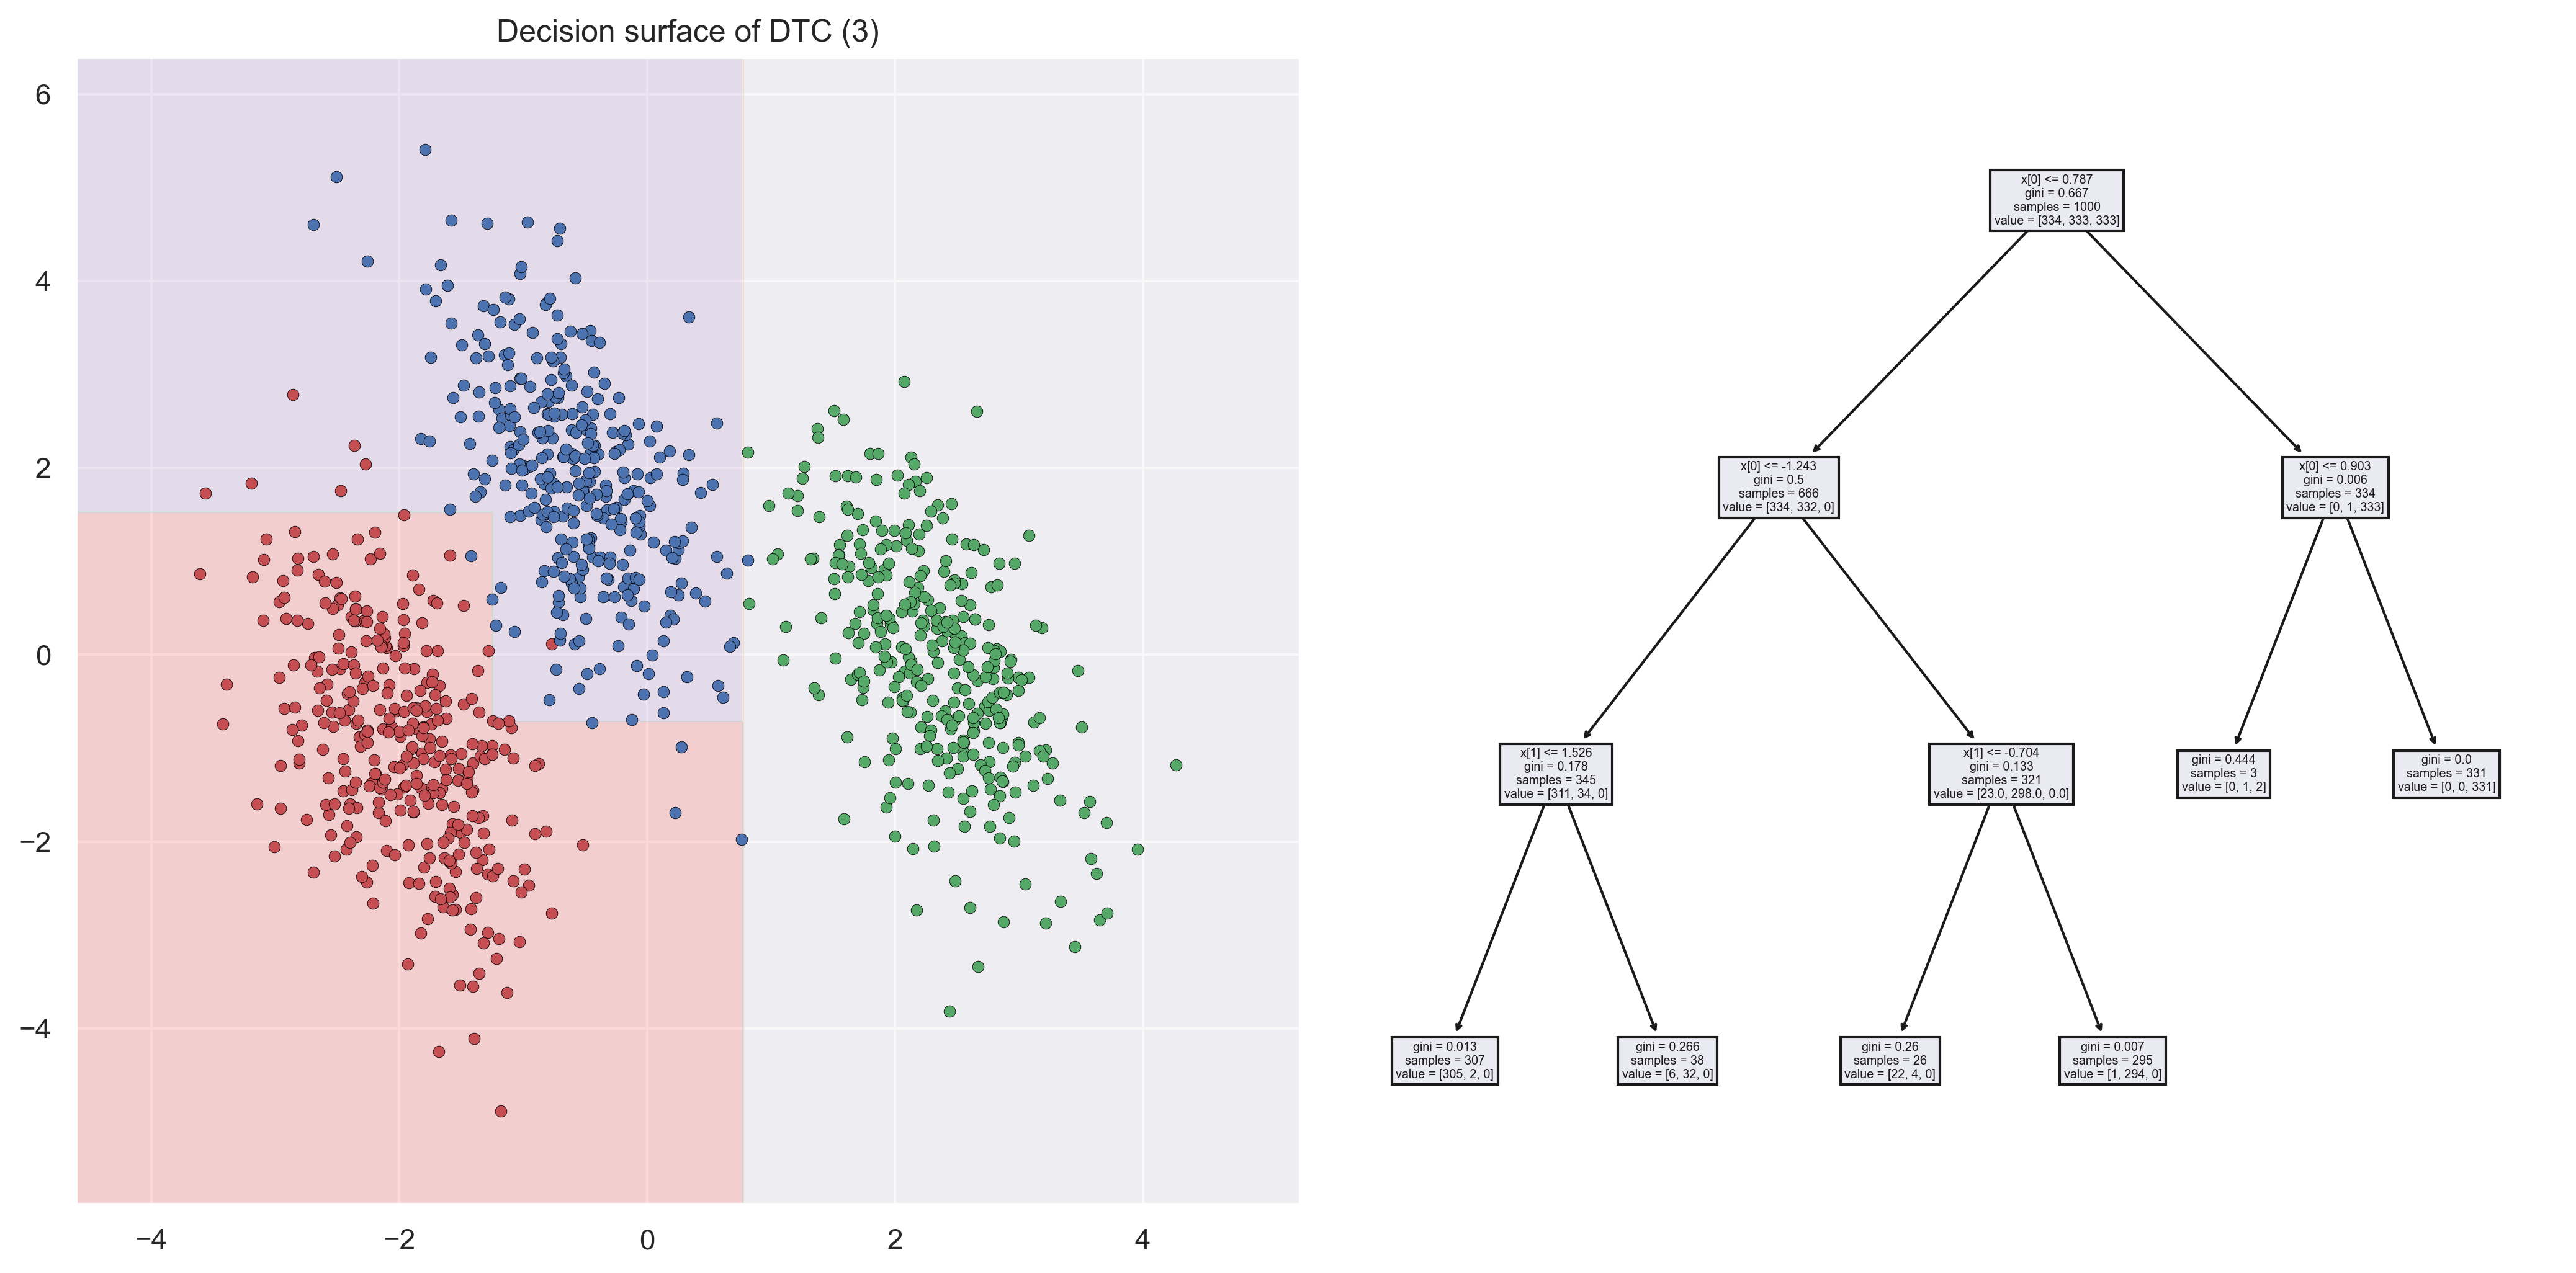

training score : 0.994 (depth=4)


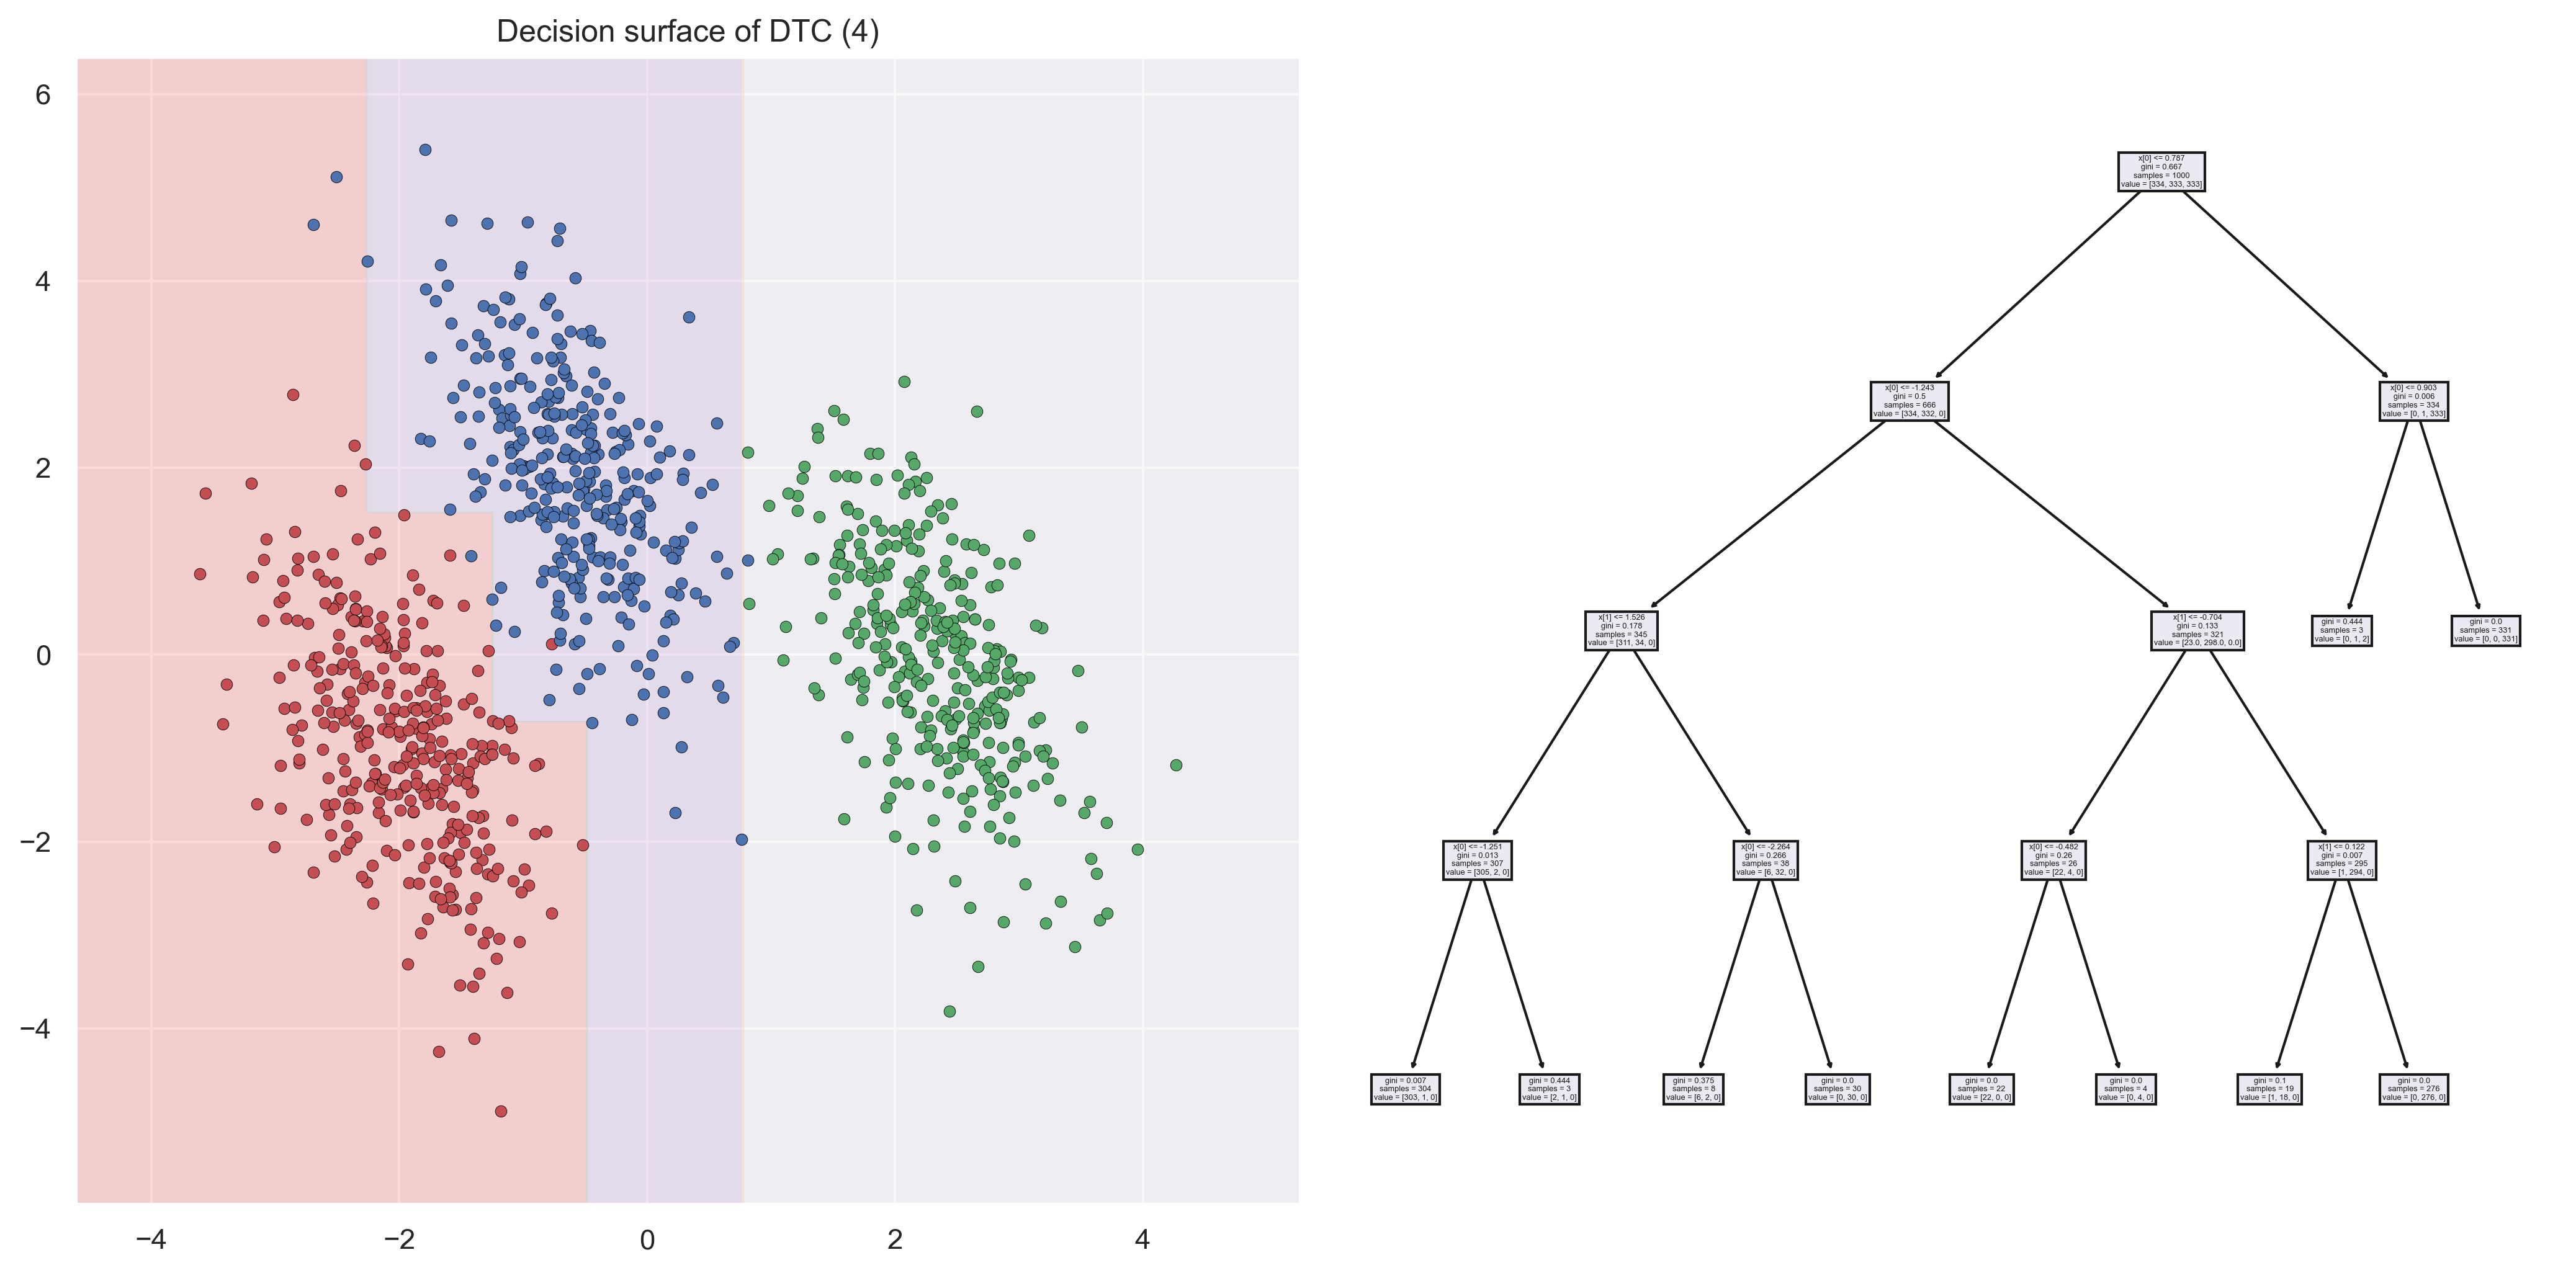

In [43]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)
dtcs = []
for depth in (1, 2, 3, 4):
    # do fit
    dtc = tree.DecisionTreeClassifier(max_depth=depth, criterion='gini', min_samples_leaf=3)  # 'entropy'
    dtcs.append(dtc)
    dtc.fit(X, y)

    # print the training scores
    print("training score : %.3f (depth=%d)" % (dtc.score(X, y), depth))

    # get range for visualization
    x_0 = X[:, 0]
    x_1 = X[:, 1]
    x_min = x_0.min() - 1
    x_max = x_0.max() + 1
    y_min = x_1.min() - 1
    y_max = x_1.max() + 1

    fig, ax = plt.subplots(1, 2,  figsize=(14,7), dpi=300)
    plot_prediction_2d(x_min, x_max, y_min, y_max, classifier=dtc, ax=ax[0])

    ax[0].set_title("Decision surface of DTC (%d)" % depth)

    # Plot also the training points
    colors = "rbg"
    for i, color in zip(dtc.classes_, colors):
        idx = np.where(y == i)
        ax[0].scatter(x_0[idx], x_1[idx], c=color,
                    edgecolor='black', s=20, linewidth=0.2)

    with plt.style.context('classic'):
      tree.plot_tree(dtc, ax=ax[1]);

    plt.tight_layout()
    plt.show()

But how is the tree constructed from a labelled training set? We distinguish here classification and regression:

***-classification***

We are given a sample $S$ of points (data-cloud), represented in feature space by some vectors $x_i,i=1...N$. We also suppose that each point has been assigned to one of $C$ classes, $c_i,i=1..N, c_i \in \{1,..,C\}$. Under this setting we can evaluate the class proportions $p_c=\frac{N_c}{N}$ where $N_c$ is the number of points belonging to class $c$.

* the Gini index of the sample is then defined as:
$$G(S) = 1 - \sum_c {p_c^2}, $$

* the Entropy is:
$$E(S) =  - \sum_c {p_c \times log(p_c)}, $$

These are called `impurity measures`.

The optimization is performed in a greedy manner, one split at a time. First a coordinate is chosen and a cutoff $a$. Points $i$ such that $x_{i,k}<a$ go to the left child node, points If $x_{i,k} \ge a$ go to the right child node. We define $S_{<}$, $S_{>}$ as the set of points belonging to the left/right child and $N_{<}$ and $N_{>}$ the corresponding number of points. The information gain of/after the split is defined as:

$$ IG = E(S) - \frac{N_{<}}{N} \times E(S_{<}) - \frac{N_{>}}{N} \times E(S_{>})$$

Same exepression holds for the Gini index. At each stage the split with the higher information gain is chosen to construct the tree. This favors that the most relevant features are used on the top of the tree and truncating/pruning a tree reduces overfitting.

***-regression***

The regression framework has a lot in common with the classification one. We always start with a sample $S$ of points in feature space $x_i,i=1...N$, but this time the targets are scalar values $y_i \in \mathbf{R}$. Instead of the impurity measures we use the sample variance as a criterion to check the quality of the sample:

$$V(S)=\frac{1}{N} \sum_i (y_i - \bar y)^2$$

Note that in the regression case we have a simplication of prefactors. If we call $y_<$ the mean of the left points and $y_>$ the mean of the right points the role of the information gain here is taken by:

$$\frac{N_{<}}{N} \times V(S_{<}) + \frac{N_{>}}{N} \times V(S_{>})=\frac{1}{N}\left(\sum_{i \in S_<} (y_i-y_<)^2+\sum_{i \in S_>} (y_i-y_>)^2\right)$$

So the information gain is replaced by the `reduction in variance` after predicting a different mean for the points belonging to the left and right children (convince yourself that this is the intepretation of the previous formula). As before to grow a tree the cut with the maximum information gain/reduction in variance is preferred.

These are also known as the CART (classification and regression trees) splitting criteria.


In [105]:
pip install dtreeviz==1.4.0

Note: you may need to restart the kernel to use updated packages.


In [44]:
from dtreeviz.trees import dtreeviz # remember to load the package

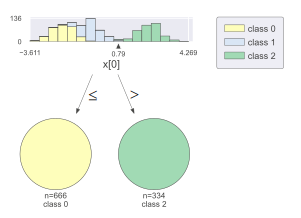

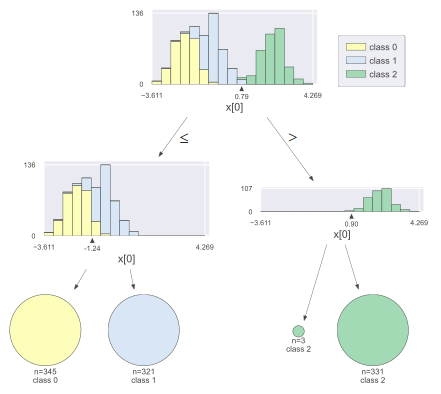

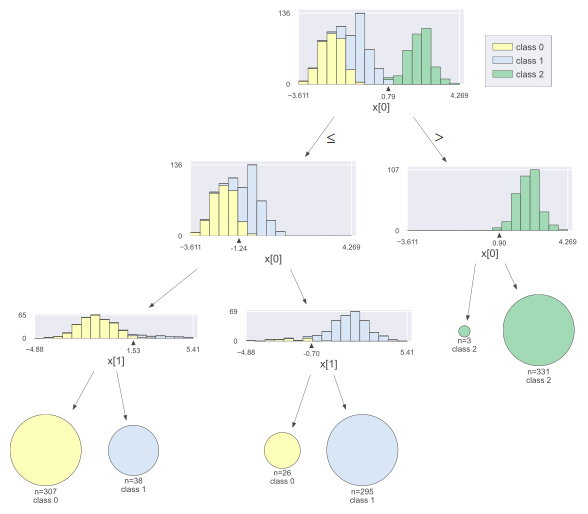

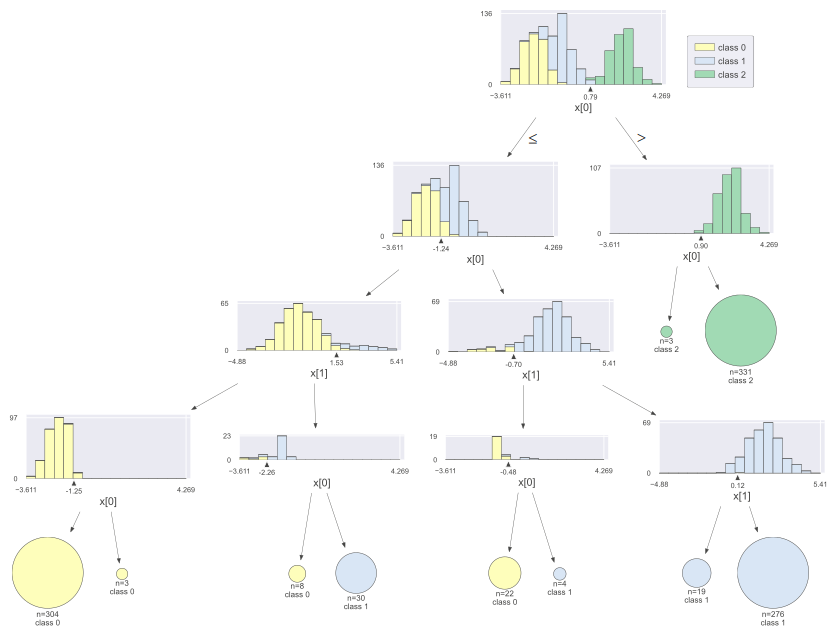

In [47]:
import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

for i, dtc in enumerate(dtcs):
  viz = dtreeviz(dtc, X, y, feature_names=['x[0]', 'x[1]'])
  viz.scale=1.2
  display(viz)


## 2. Random Forest

The `sklearn.ensemble` provides several ensemble algorithms. RandomForest is an averaging algorithm based on randomized decision trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction.

The prediction of the ensemble is given as the averaged prediction of the individual classifiers (regression) or by majority voting (classification). E.g. for regression:

$$ RF(x) = \frac{1}{N_\text{trees}}\sum_{i=1}^{N_\text{trees}} Tree_i(x)$$

Individual decision trees typically exhibit high variance and tend to overfit.
In random forests:
* each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.
* when splitting each node during the construction of a tree, the best split is found from a random subset of features, according to `max_features` parameter.

The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant, hence yielding an overall better model.


training score : 0.980 (n_est=1)


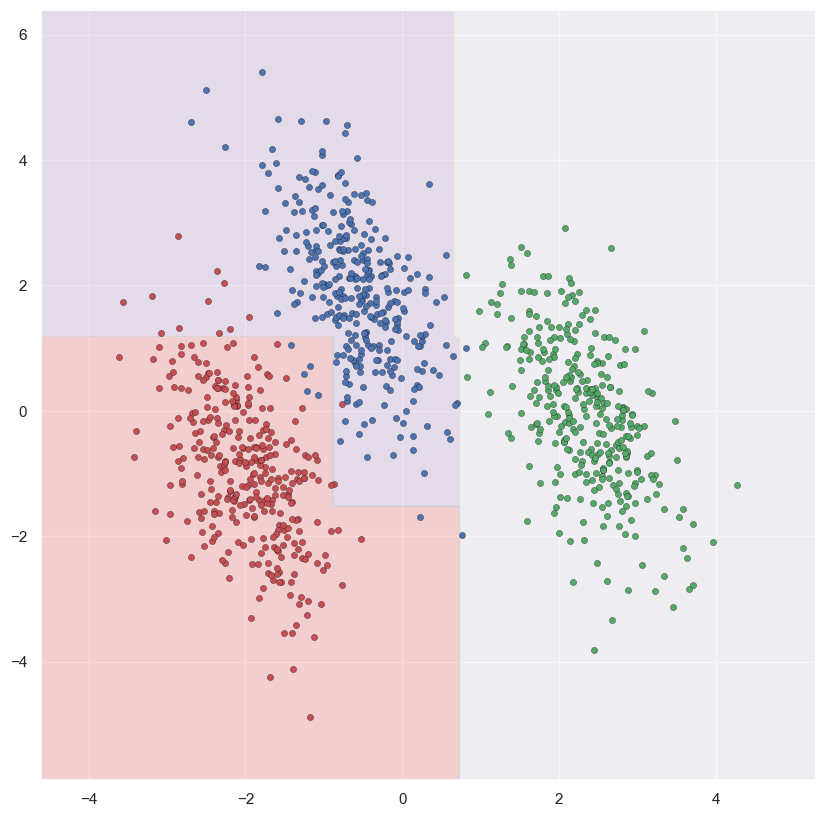

training score : 0.992 (n_est=4)


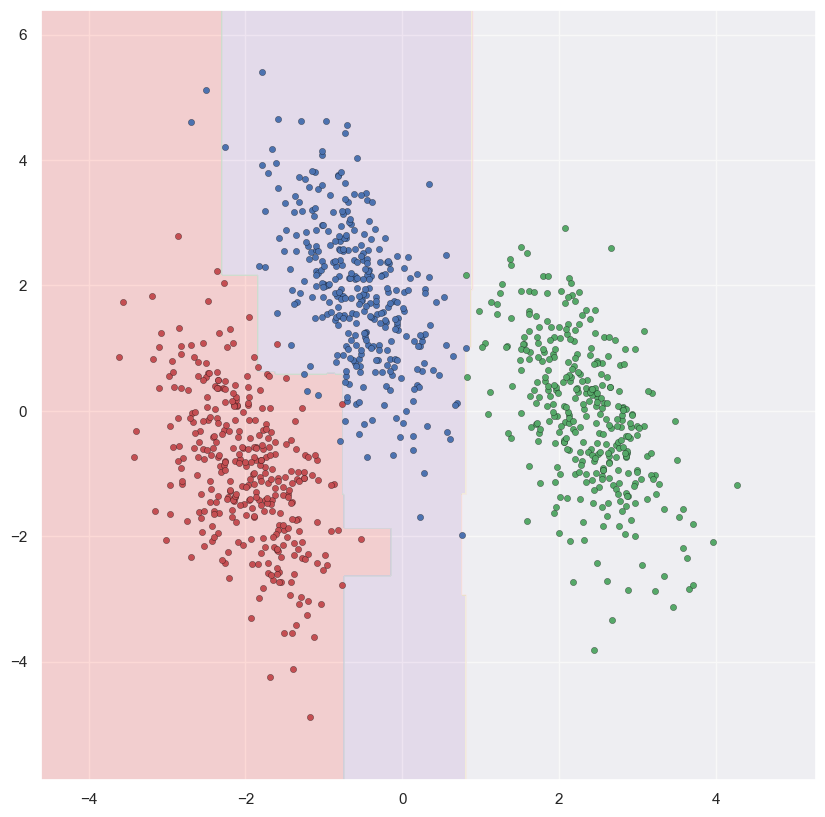

training score : 0.998 (n_est=50)


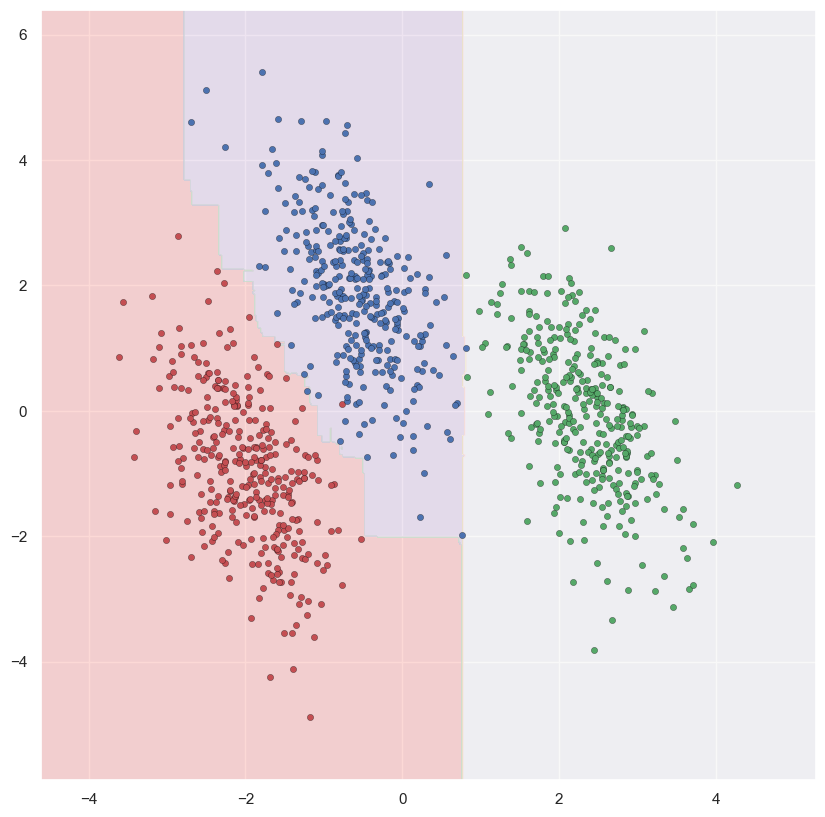

In [49]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

for n_est in (1, 4, 50):
    # do fit
    rfc = ensemble.RandomForestClassifier(max_depth=4, n_estimators=n_est,) # you don't have more cuts than the number of features
    rfc.fit(X, y)

    # print the training scores
    print("training score : %.3f (n_est=%d)" % (rfc.score(X, y), n_est))

    # get range for visualization
    x_0 = X[:, 0]
    x_1 = X[:, 1]
    x_min = x_0.min() - 1
    x_max = x_0.max() + 1
    y_min = x_1.min() - 1
    y_max = x_1.max() + 1

    plt.figure(figsize=(10,10))
    plot_prediction_2d(x_min, x_max, y_min, y_max, classifier=rfc)

    # Plot also the training points
    colors = 'rbg'
    for i, color in enumerate(colors):
        idx = np.where(y == i)
        plt.scatter(x_0[idx], x_1[idx], c=color,
                    edgecolor='black', s=20, linewidth=0.2)


    plt.show()

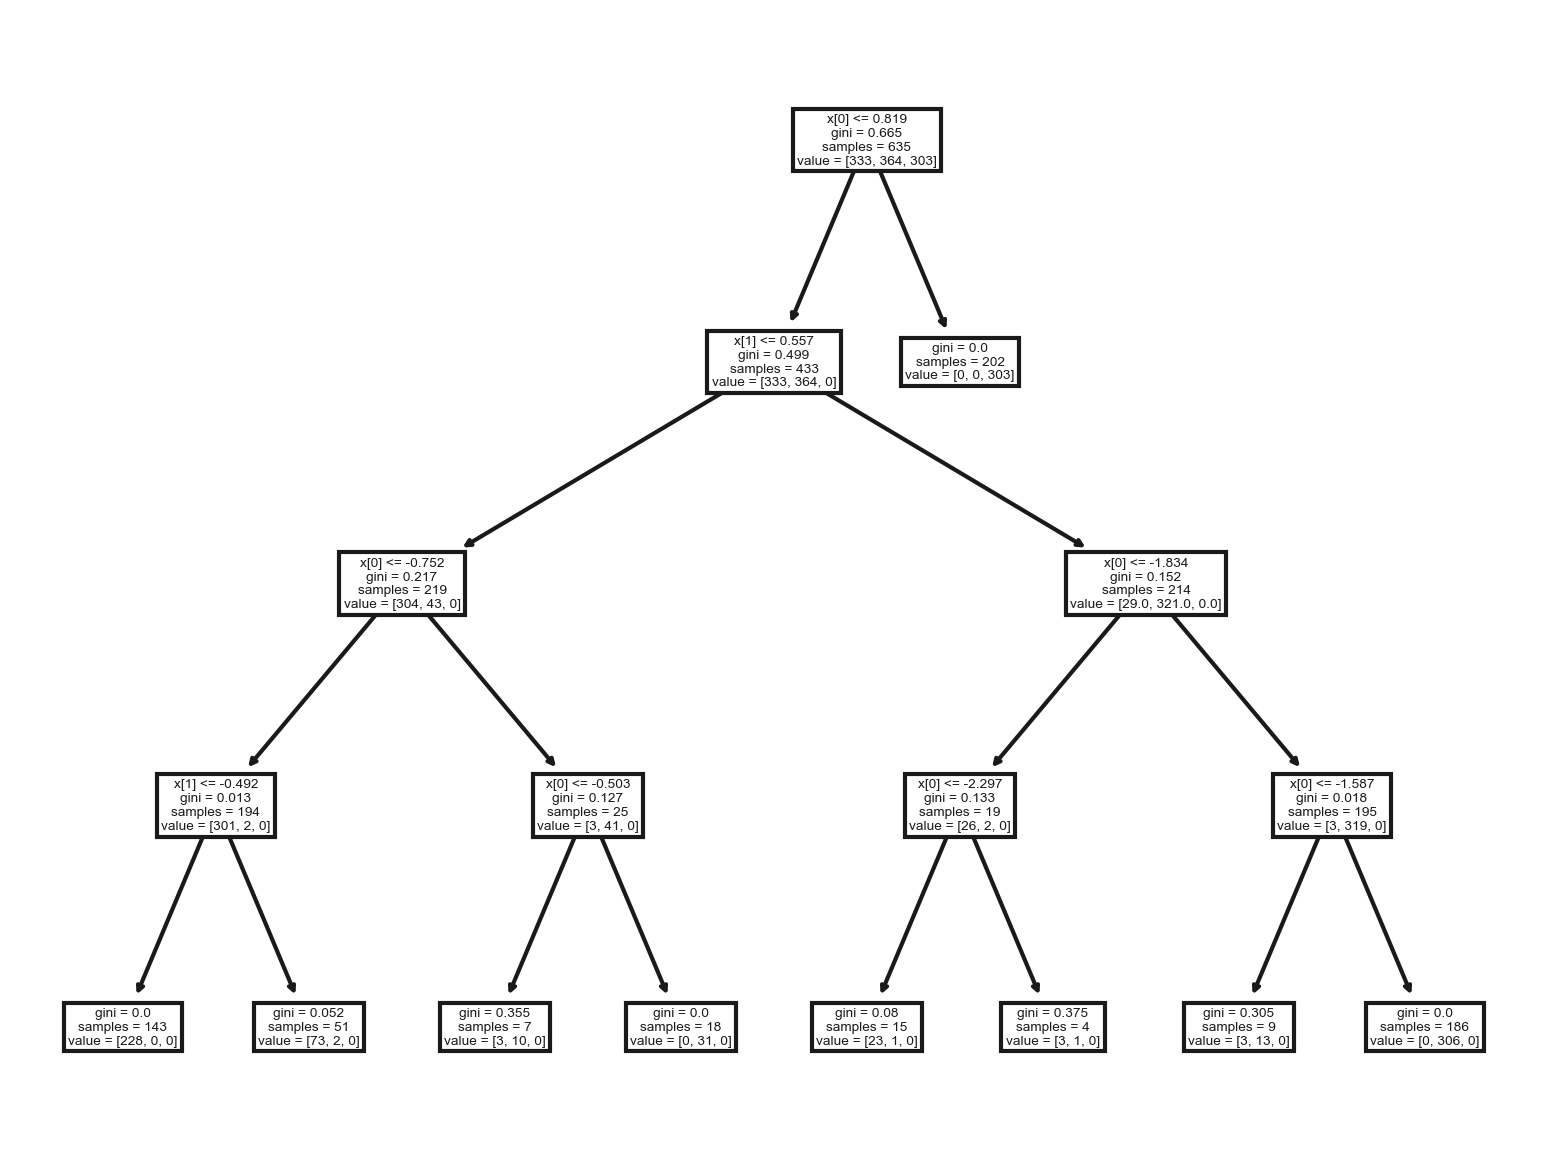

In [51]:
plt.figure(dpi=300)
with plt.style.context('classic'):
  tree.plot_tree(rfc.estimators_[20]);

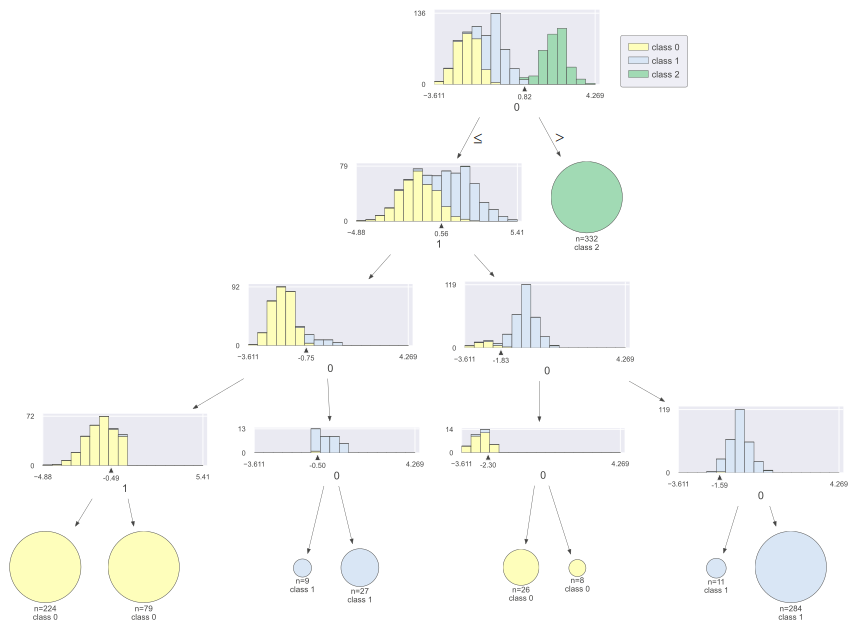

In [53]:
viz = dtreeviz(rfc.estimators_[20], X, y, feature_names=[f'{i}' for i in np.arange(len(X[0]))])
viz.scale=1.2
display(viz)

## 3. Boosted Decision Trees

Another approach to the ensemble tree modeling is Boosted Decision Trees. In a boosting framework, the trees are created sequentially. This way each next tree reduces error of the ensemble, by adding corrections to previous predictions.

Corrections to the predictions of boosted decision trees are sequentially added, in contrast with random forest predictions:

$$ Boost(x) = Tree_0(x)+\lambda \sum_{i=1}^{N_\text{trees}} Tree_i(x)$$

Notes:

- The trees used at each step are very shallow trees (with high biased). Boosting is a way to combine `weak` classifiers (high bias, low variance) and decrease bias and increase variance gradually, in a controlled way.

- $\lambda$ is a parameters, called shrinkage or learning rate, that describes how fast we are changing the predictions at each step. A smaller learning rate is useful to control overfitting.

- Predictions and classifications are treated often on the same footing, by making the ensemble output logits.



One of the most popular implementations of boosting is XGBoost:

https://arxiv.org/abs/1603.02754

https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [67]:
pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 640.0 kB/s eta 0:03:16
   ---------------------------------------- 0.2/124.9 MB 2.2 MB/s eta 0:00:56
   ---------------------------------------- 0.5/124.9 MB 4.2 MB/s eta 0:00:30
   ---------------------------------------- 0.8/124.9 MB 5.3 MB/s eta 0:00:24
   ---------------------------------------- 1.2/124.9 MB 5.5 MB/s eta 0:00:23
   ---------------------------------------- 1.4/124.9 MB 5.4 MB/s eta 0:00:24
   ---------------------------------------- 1.5/124.9 MB 4.9 MB/s eta 0:00:26
    --------------------------------------- 2.0/124.9 MB 5.4 MB/s eta 0:00:23
    --------------------------------------- 2.1/124.9 MB 5.2 MB/s eta 0:00:24
    --------------------------------------- 2.3/124.9 MB 5.0 MB/s eta 0:00:25
    --------------------------------------- 2.5/124.9 MB 4.9 MB/s eta 0:00:25
    --------------------------------------- 2.7/124.9 MB 4.9 MB/s eta

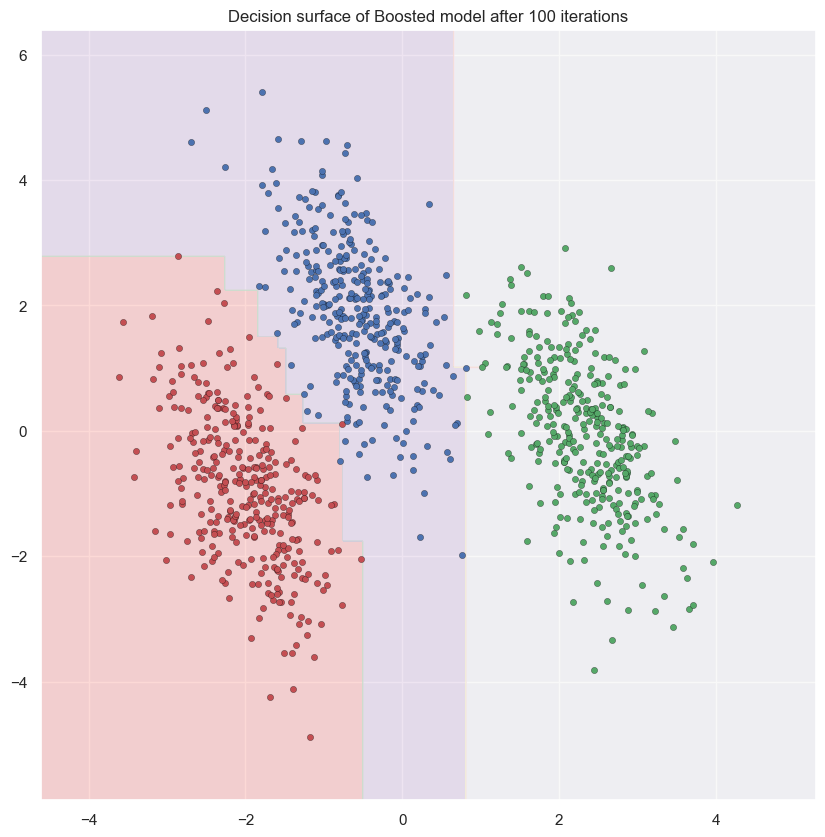

In [55]:
from xgboost import XGBClassifier

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

params = {
    'num_class': 3,               # Number of classes in the target variable
    'max_depth': 3,               # Maximum depth of trees
    'learning_rate': 0.1,         # Learning rate
    'n_estimators': 100
}
model = XGBClassifier(**params)
model.fit(X, y, verbose=True)

# print the training scores
#print("training score : %.3f (n_est=%d)" % (dtc.score(X, y), n_est))
x_0 = X[:, 0]
x_1 = X[:, 1]
x_min = x_0.min() - 1
x_max = x_0.max() + 1
y_min = x_1.min() - 1
y_max = x_1.max() + 1
plt.figure(figsize=(10,10))
plot_prediction_2d(x_min, x_max, y_min, y_max, classifier = model)

plt.title(f'Decision surface of Boosted model after 100 iterations')
plt.axis('tight')

# Plot also the training points
colors = 'rbg'
for i, color in enumerate(colors):
    idx = np.where(y == i)
    plt.scatter(x_0[idx], x_1[idx], c=color,
                edgecolor='black', s=20, linewidth=0.2)

# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()


plt.show()

In [57]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

x, y = house_prices_dataset()

# Split your data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

evals_result = {}
# Create an XGBoost regression model
model = XGBRegressor(eval_metric='rmse' ,
                     max_depth = 5, 
                     early_stopping_rounds = 10, 
                     learning_rate = 0.3, 
                     n_estimators = 1000 )

# Train the XGBoost regression model
model.fit(x_train, y_train, 
          eval_set=[(x_train, y_train),(x_test, y_test)], 
          verbose=True)

y_p_train = model.predict(x_train)
y_p_test = model.predict(x_test)

[0]	validation_0-rmse:49848.44871	validation_1-rmse:52927.00357
[1]	validation_0-rmse:39332.42187	validation_1-rmse:42995.09536


C:\Users\vuill\AppData\Local\Temp\ipykernel_15420\3540711033.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical


[2]	validation_0-rmse:32094.14052	validation_1-rmse:36312.80745
[3]	validation_0-rmse:27454.39373	validation_1-rmse:32197.24964
[4]	validation_0-rmse:23876.27756	validation_1-rmse:29401.36284
[5]	validation_0-rmse:21728.30234	validation_1-rmse:27697.32366
[6]	validation_0-rmse:20057.99724	validation_1-rmse:26645.65574
[7]	validation_0-rmse:19137.03307	validation_1-rmse:26150.36645
[8]	validation_0-rmse:18300.47746	validation_1-rmse:25990.03501
[9]	validation_0-rmse:17738.56706	validation_1-rmse:25659.68039
[10]	validation_0-rmse:17284.23687	validation_1-rmse:25420.43855
[11]	validation_0-rmse:17002.08332	validation_1-rmse:25314.50059
[12]	validation_0-rmse:16740.20544	validation_1-rmse:25184.35674
[13]	validation_0-rmse:16562.58278	validation_1-rmse:25005.63404
[14]	validation_0-rmse:16357.17377	validation_1-rmse:24954.70473
[15]	validation_0-rmse:15999.69141	validation_1-rmse:25011.27337
[16]	validation_0-rmse:15931.46612	validation_1-rmse:24995.56449
[17]	validation_0-rmse:15792.5534

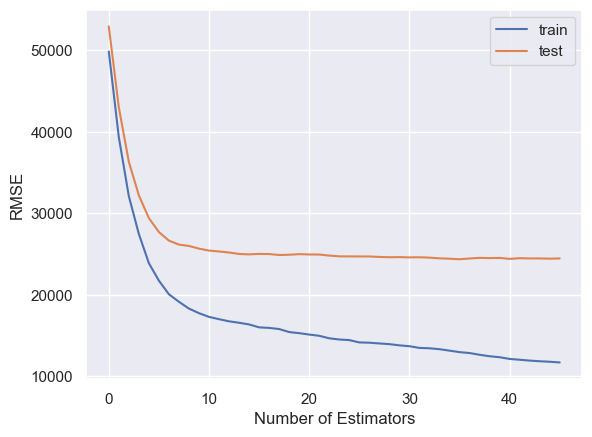

In [59]:
plt.plot(model.evals_result_['validation_0']['rmse'], label='train')
plt.plot(model.evals_result_['validation_1']['rmse'], label='test')
plt.legend()
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.show()

train mse = 12959.51
test mse = 24355.441
train mse = 12959.512
train mse = 24358.525
train mae = 9583.999
test mae = 16987.979
train R2 = 0.9606472324668677
test R2 = 0.8734698886750615


[]

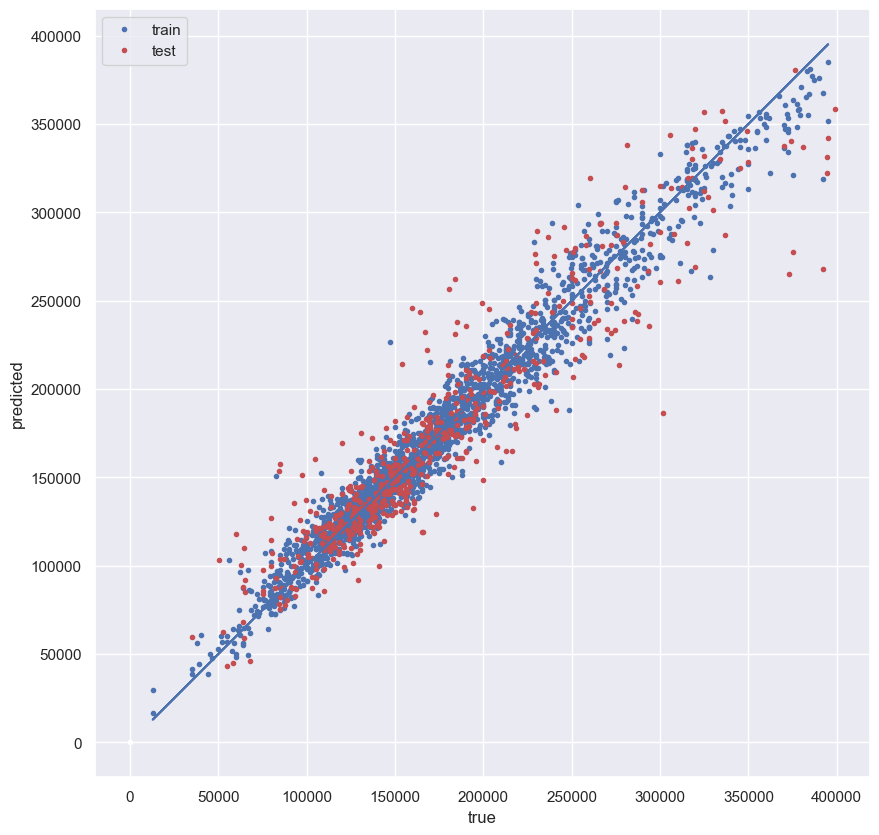

In [61]:
from sklearn.metrics import r2_score

# mse
print('train mse =', np.std(y_train - y_p_train))
print('test mse =', np.std(y_test - y_p_test))

residuals=y_train - y_p_train
print('train mse =', np.sqrt( np.mean(residuals**2)) )
residuals=y_test - y_p_test
print('train mse =', np.sqrt( np.mean(residuals**2)) )

# mse
print('train mae =', np.mean(np.abs(y_train - y_p_train)))
print('test mae =', np.mean(np.abs(y_test - y_p_test)))
# R2
print('train R2 =', r2_score(y_train, y_p_train))
print('test R2 =', r2_score(y_test, y_p_test))


# 4. plot y vs predicted y for test and train parts
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')

plt.plot(y_train, y_train,'-')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.legend()
plt.plot()

## EXERCISE 3 : Random forest for FMNIST

Classify fashion MNIST images with Random Forest classifier. This is similar to Ex 2 (Logistic Regression for FMNIST) but you have to play with a different classifier.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [5]:
# Repeat the steps of Ex. 2, but in step 3 when fitting the model, you can play with r.f. parameters.
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# This is a normalization step, which can help the training of some models. It does not hurt anyway 

train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0

#Helper function for point 2

def extract_features(images):
    def compute_power_spectrum(image):
        fourier_transform = np.fft.fft2(image)
        power_spectrum = np.abs(fourier_transform) ** 2
        power_spectrum /= np.sum(power_spectrum)
        return power_spectrum.flatten()
    power_spectrum_features = []
    for img in images:
        spectrum = compute_power_spectrum(img)
        power_spectrum_features.append(spectrum)
    return np.array(power_spectrum_features)

train_features = extract_features(train_images_norm)
test_features = extract_features(test_images_norm)


# TIP:  You can use verbose = 2 to see the training progress (in case it is too slow) and n_jobs=-1 to use all available corse: ensemble.RandomForestClassifier(..., verbose=2, n_jobs=-1)

In [6]:
type(train_features)

numpy.ndarray

In [7]:
type(train_labels)

numpy.ndarray

In [118]:
# 1. Create classifier
# 2. Extract Features
# 3. fit the model

# 1. Create classifier
clf = ensemble.RandomForestClassifier(max_depth=7, n_estimators=50, n_jobs=-1,verbose=2)

# 2. fit the model
t1 = timer()
clf.fit(train_features, train_labels)
t2 = timer()
print ('training time: %.1fs'%(t2-t1))

# 3. evaluate accuracy on train and test datasets
print("training score : %.3f" % (clf.score(train_features, train_labels)))
print("test score : %.3f" % (clf.score(test_features, test_labels)))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:   13.3s remaining:   38.0s


building tree 47 of 50
building tree 48 of 50
building tree 49 of 50building tree 50 of 50



[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   19.3s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


training time: 21.2s


[Parallel(n_jobs=32)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=32)]: Done  39 out of  50 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    0.2s finished


training score : 0.781
test score : 0.763


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=32)]: Done  39 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    0.0s finished


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  39 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    0.0s finished


[[702   3  71 117  26  27  27   0  18   9]
 [  5 897  10  68   8   1   6   0   5   0]
 [ 29   0 672  19 159   8  79   0  31   3]
 [ 49  13  19 871  13   5  22   0   6   2]
 [ 83   0 125 104 572  10  88   0  14   4]
 [  0   0   0   1   0 904   0  69   3  23]
 [189   1 172 108 113  19 335   0  56   7]
 [  0   0   0   0   0  40   0 849   0 111]
 [  4   0  25   3   8  32   4   7 898  19]
 [  4   0   0   5   0  26   0  30   3 932]]
Check that you get the same accuracy from the score method: 0.7632


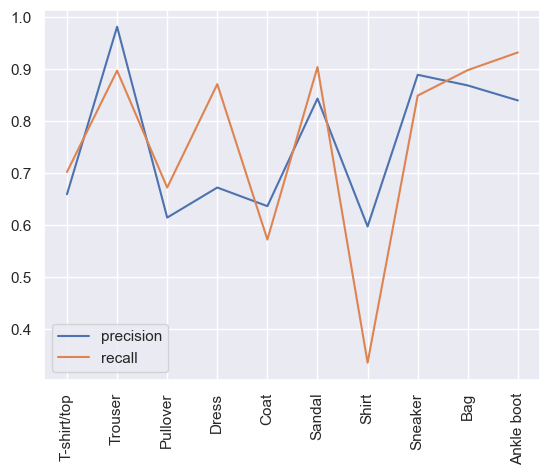

In [119]:
test_labels_pred = clf.predict(test_features)

from sklearn import metrics
cm=metrics.confusion_matrix( test_labels, test_labels_pred )
print(cm)

print(f'Check that you get the same accuracy from the score method: {np.sum([cm[i,i] for i in range(10)])/np.sum(cm)}')

def get_class_specific_prec_recall(cm):
    n_cat=cm.shape[0]
    precisions=[]
    recalls=[]
    #precision
    for i in range(n_cat):
        precisions.append(cm[i,i]/np.sum(cm[:,i]))

    #recall
    for i in range(n_cat):
        recalls.append(cm[i,i]/np.sum(cm[i,:]))
    return precisions, recalls

precisions, recalls = get_class_specific_prec_recall(cm)

plt.plot(fmnist_class_names,precisions, label='precision')
plt.plot(fmnist_class_names,recalls, label='recall')
plt.xticks(rotation=90)
plt.legend()

plt.show()

In [121]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 2,
 'warm_start': False}

Once you are done, call clf.get_params() and update the google doc here with your findindgs!

https://docs.google.com/document/d/1f5sDOS_cq1_ZaUkwlSnog5I8jpYiK_QAF1hk3vcBFL8/edit?usp=sharing

## Debugging and Understanding models: feature importance.

Understanding the way a model is reaching each decisions is a subfield of **Interpretable Machine Learning**. It is important for debugging purposes and model development. 

Many methods produce a feature importance plot. The easiest flavor is the **permutation feature importance** (https://scikit-learn.org/stable/modules/permutation_importance.html). 

This is based on the following methodology, which returns for each feature a scalar value:

1. **Train Model**
   - Fit model on training data and compute `baseline_score`.

2. **For each feature `f`:**
   - Shuffle `f` in validation data.
   - Compute `shuffled_score` with the model.
   - Calculate `importances[f] = baseline_score - shuffled_score`.

3. **(Optional) Normalization**
   - Normalize the `importances` vector to have positive values and sum to one.
   
For **Random Forest** models, an other tree-based type of feature importance is stored in the model attribute. This is much faster to plot than the permutation feature importance.


EXAMPLE: Feature importance study for Ex. 3 (Code in Solutions):

p_importances = permutation_importance(clf, test_features, test_labels, n_repeats=10, n_jobs=-1) 

rf_importances = clf.feature_importances_


<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/FMNIST_feature_importance.png" width="80%"/>
<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/FMNIST_feature_importance_2.png" width="80%"/>

LIMITATIONS:

1.  The samples generated may be out-of-distribution, therefore uninteresting or belonging to a region where the model returns random values
2.  In the presence of correlated features a model can rely on one or the other feature for prediction. This may lead to misleading interpetations.

PARTIAL SOLUTION: perform a study of the correlation between the variables to interpret the validation plot.





FURTHER READINGS (advanced):

1. "Why Should I Trust You?": Explaining the Predictions of Any Classifier, https://arxiv.org/abs/1602.04938
2. "Explaining individual predictions when features are dependent: More accurate approximations to Shapley values", https://arxiv.org/abs/1903.10464
3. https://shap.readthedocs.io/en/latest/overviews.html

In [122]:
p_importances = permutation_importance(clf, test_features, test_labels, n_repeats=10, n_jobs=-1) #NB: expensive on Colab
rf_importances = clf.feature_importances_

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  39 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    0.0s finished


In [127]:
def plot_importances(p_importances, label):
    fig,ax=plt.subplots(1,2,figsize=(19,5))
    y=np.abs(p_importances)
    y=y/np.sum(y)
    ax[0].plot(y)
    ax[0].set_xlabel('Feature index')
    ax[0].set_ylabel(label)
    mod_freq=[]
    for fx in np.fft.fftfreq(28):
        for fy in np.fft.fftfreq(28):
            mod_freq.append(np.sqrt(fx**2+fy**2))
    mod_freq=np.array(mod_freq)
    sorted_indices = np.argsort(mod_freq)
    x = mod_freq[sorted_indices]
    ax[1].plot(x, y[sorted_indices],'-o', markersize=2)
    ax[1].set_xlabel('Wavelength modulus')
    ax[1].set_ylabel(label)
    return fig

Text(0.5, 0.98, 'FMNIST Classification with power spectrum - permutation feature importance')

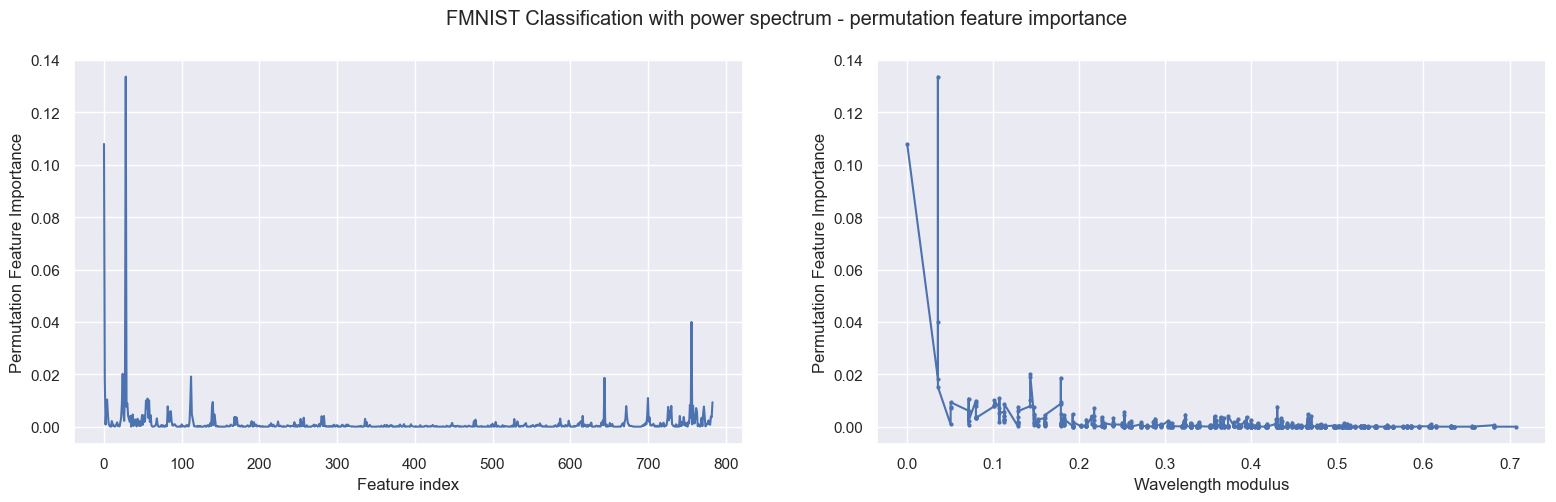

In [129]:
fig=plot_importances(p_importances['importances_mean'], label='Permutation Feature Importance')
fig.suptitle('FMNIST Classification with power spectrum - permutation feature importance')

Text(0.5, 0.98, 'FMNIST Classification with power spectrum - Tree-based feature importance')

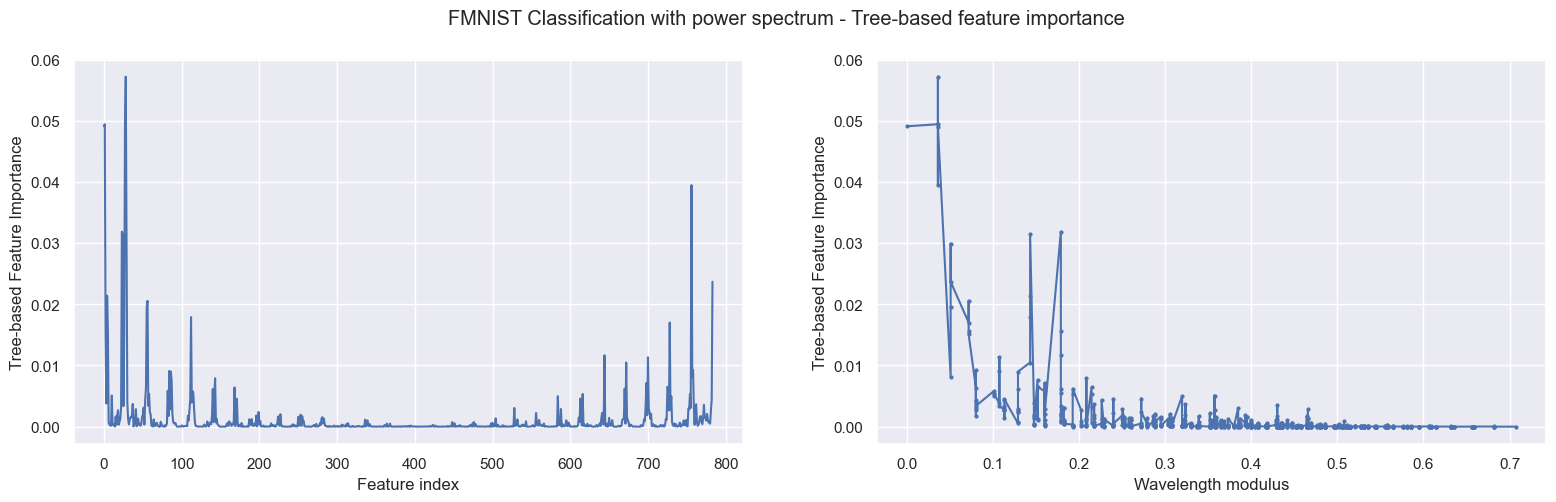

In [131]:
fig=plot_importances(rf_importances, label='Tree-based Feature Importance')
fig.suptitle('FMNIST Classification with power spectrum - Tree-based feature importance')

0.9999999999999998


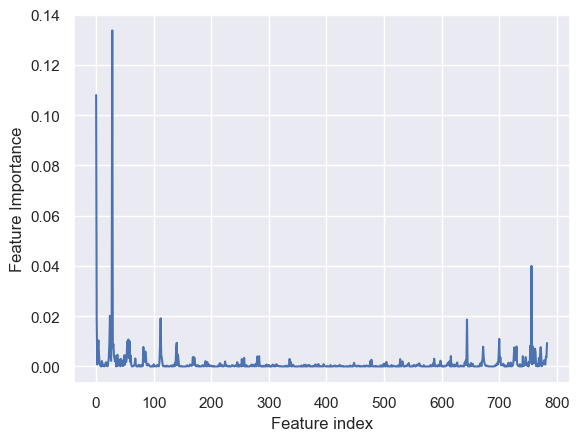

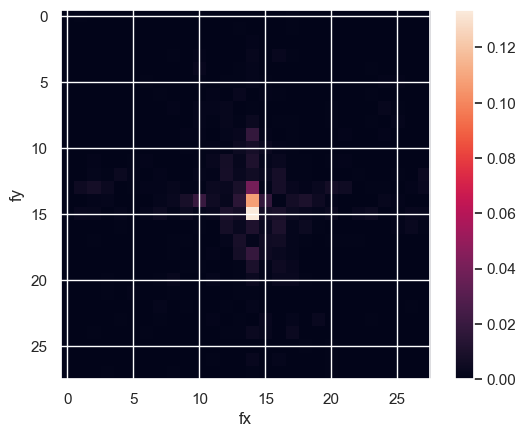

In [133]:
# 2-D visualization of the Feature Importance 

p_importances_reshaped=np.abs(p_importances['importances_mean']).reshape(28,28)
p_importances_reshaped=p_importances_reshaped/np.sum(p_importances_reshaped)
print(np.sum(p_importances_reshaped))
plt.plot(p_importances_reshaped.flatten())
plt.xlabel('Feature index')
plt.ylabel('Feature Importance')
plt.figure()
p_importances_reshaped=np.fft.fftshift(p_importances_reshaped)
plt.imshow(p_importances_reshaped)
plt.xlabel('fx')
plt.ylabel('fy')
plt.colorbar() 

## EXERCISE 4 (Optional): Random forest/XGboost regression for AMES with Feature Imporance


In [77]:
X, y, (df_x, df_y) = house_prices_dataset(return_df_xy=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

C:\Users\vuill\AppData\Local\Temp\ipykernel_15420\3540711033.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical


Predict the house prices using either a RandomForest model or boosted tree (choose one). Some suggestion lines:

- model = ensemble.RandomForestRegressor(max_depth=... n_estimators= ...)

- model = XGBRegressor(eval_metric='rmse' ,max_depth= ..., learning_rate = ..., n_estimators = ... )
model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=True)

Use permutation importance for the feature importance.

In [81]:
# 1. Review the examples showcasing the usage of the random forest model or xgboost.

# 2. Fit the model

clf = ensemble.RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1,verbose=2)

# 2. fit the model
t1 = timer()
clf.fit(x_train,y_train)
t2 = timer()
print ('training time: %.1fs'%(t2-t1))

# 3. evaluate accuracy on train and test datasets
print("training score : %.3f" % (clf.score(x_train, y_train)))
print("test score : %.3f" % (clf.score(x_test, y_test)))

# 4. Try to improve performance by adjusting hyperparameters.


# How does it compare to linear model? Can you make a plot of y_pred vs y_exact as you did for a linear model and compare visually ?

# 5. Study the feature importance
 
# Heper code for plotting the permutation feature importances in this dataset:
def plot_importances(feature_names, permutation_importances):
    plt.figure(figsize=(8, 10))
    plt.barh(feature_names,
            permutation_importances.importances_mean,
            yerr=permutation_importances.importances_std, )
    plt.ylabel('feature')
    plt.xlabel('importance')
    plt.xlim(0, 1)
    return 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.1s remaining:    0.4s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  13 out of  50 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=32)]: Done  39 out of  50 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


training score : 0.751
test score : 0.005


[Parallel(n_jobs=32)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=32)]: Done  39 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    0.0s finished


In [83]:
rfr = ensemble.RandomForestRegressor(max_depth=5, n_estimators=30)
rfr.fit(x_train, y_train)
rfr.score(x_test, y_test)

0.8445118850119849

In [85]:
rfr = ensemble.RandomForestRegressor(max_depth=30, n_estimators=70)
rfr.fit(x_train, y_train)
rfr.score(x_test, y_test)

0.8813360730088451

[]

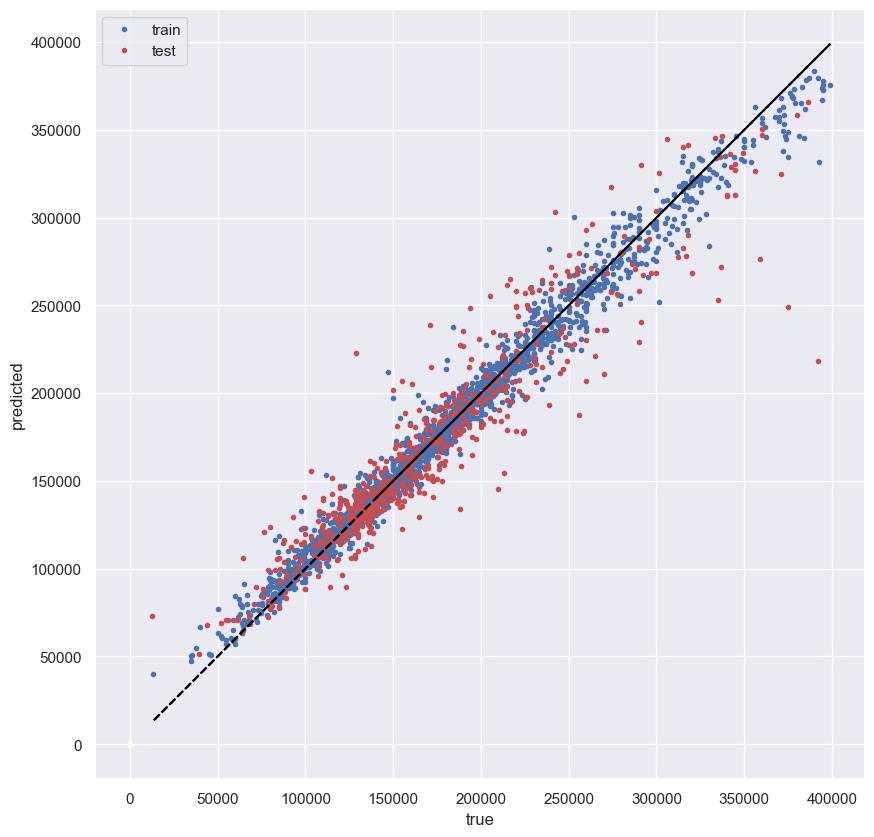

In [87]:
y_p_train = rfr.predict(x_train)
y_p_test = rfr.predict(x_test)


# 4. plot y vs predicted y for test and train parts
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')
plt.plot(y_train,y_train,'--',color='black')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.legend()
plt.plot()

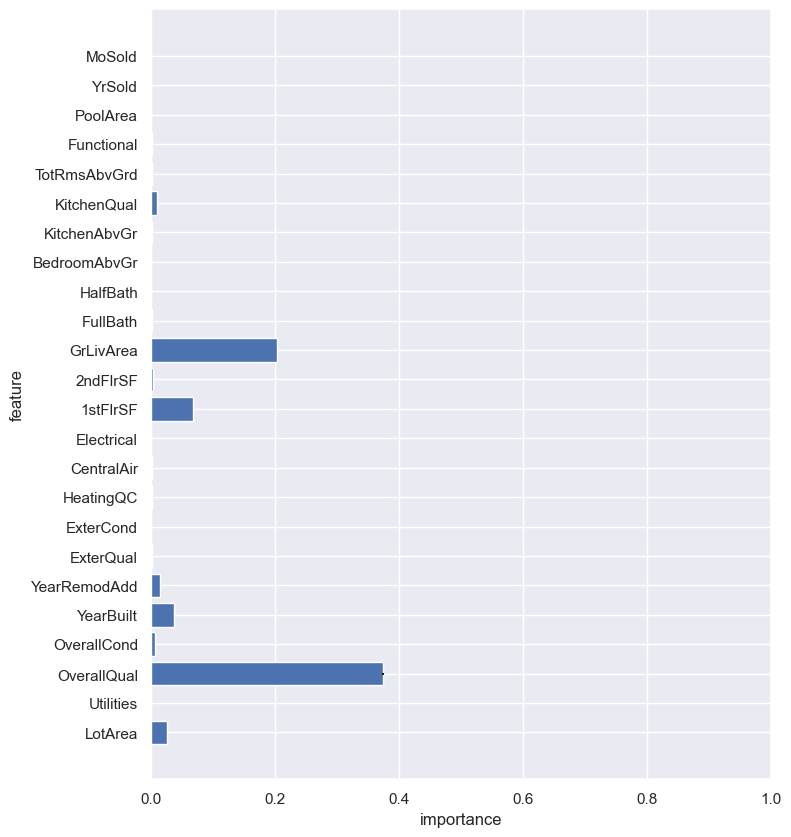

In [89]:
p_importances = permutation_importance(rfr, x_test, y_test, n_repeats=10, n_jobs=-1)

def plot_importances(feature_names, permutation_importances):
        plt.figure(figsize=(8, 10))
        plt.barh(feature_names,
                permutation_importances.importances_mean,
                yerr=permutation_importances.importances_std, )
        plt.ylabel('feature')
        plt.xlabel('importance')
        plt.xlim(0, 1)
        return 

plot_importances(list(df_x.columns), p_importances)

In [93]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

x, y = house_prices_dataset()

# Split your data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Create an XGBoost regression model
model = XGBRegressor(eval_metric='rmse' ,max_depth= 5, learning_rate=0.3, n_estimators=100,early_stopping_rounds=5 )

# Train the XGBoost regression model
model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=True)

y_p_train = model.predict(x_train)
y_p_test = model.predict(x_test)

[0]	validation_0-rmse:49256.82636
[1]	validation_0-rmse:39730.19104
[2]	validation_0-rmse:33332.80686
[3]	validation_0-rmse:29048.37180
[4]	validation_0-rmse:26395.48486
[5]	validation_0-rmse:24701.91665
[6]	validation_0-rmse:23843.48254
[7]	validation_0-rmse:23026.04029
[8]	validation_0-rmse:22757.95634
[9]	validation_0-rmse:22277.92530
[10]	validation_0-rmse:22053.94831
[11]	validation_0-rmse:21984.48317
[12]	validation_0-rmse:21842.68424
[13]	validation_0-rmse:21740.30802
[14]	validation_0-rmse:21880.22829
[15]	validation_0-rmse:21828.00443
[16]	validation_0-rmse:21829.14357
[17]	validation_0-rmse:21749.71935
[18]	validation_0-rmse:21715.99653
[19]	validation_0-rmse:21717.92524
[20]	validation_0-rmse:21628.58816
[21]	validation_0-rmse:21650.53213
[22]	validation_0-rmse:21658.18198
[23]	validation_0-rmse:21602.26379
[24]	validation_0-rmse:21591.46790
[25]	validation_0-rmse:21618.65884


C:\Users\vuill\AppData\Local\Temp\ipykernel_15420\3540711033.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical


[26]	validation_0-rmse:21607.31658
[27]	validation_0-rmse:21590.63965
[28]	validation_0-rmse:21542.21543
[29]	validation_0-rmse:21495.53679
[30]	validation_0-rmse:21443.27857
[31]	validation_0-rmse:21422.48994
[32]	validation_0-rmse:21431.39502
[33]	validation_0-rmse:21434.42748
[34]	validation_0-rmse:21435.51259
[35]	validation_0-rmse:21470.66213


train mse = 13313.801
test mse = 21305.967
train mae = 9783.283
test mae = 15434.507
train R2 = 0.9596833433512858
test R2 = 0.8899822492294769


[]

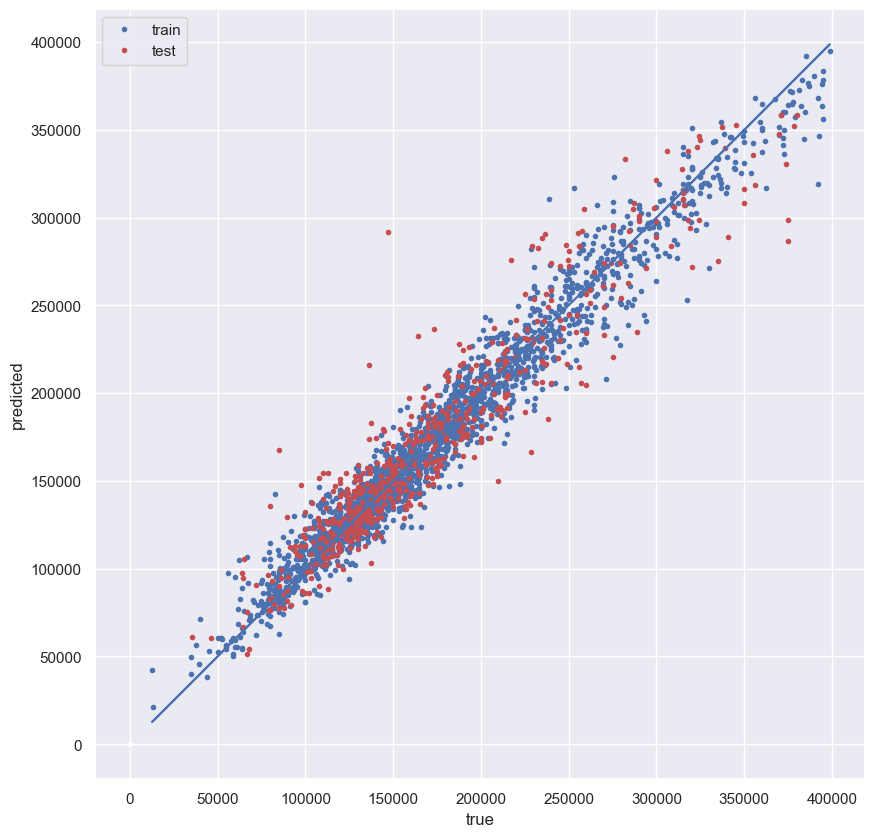

In [95]:
from sklearn.metrics import r2_score

# mse
print('train mse =', np.std(y_train - y_p_train))
print('test mse =', np.std(y_test - y_p_test))
# mse
print('train mae =', np.mean(np.abs(y_train - y_p_train)))
print('test mae =', np.mean(np.abs(y_test - y_p_test)))
# R2
print('train R2 =', r2_score(y_train, y_p_train))
print('test R2 =', r2_score(y_test, y_p_test))

# 4. plot y vs predicted y for test and train parts
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')

plt.plot(y_train, y_train,'-')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.legend()
plt.plot()

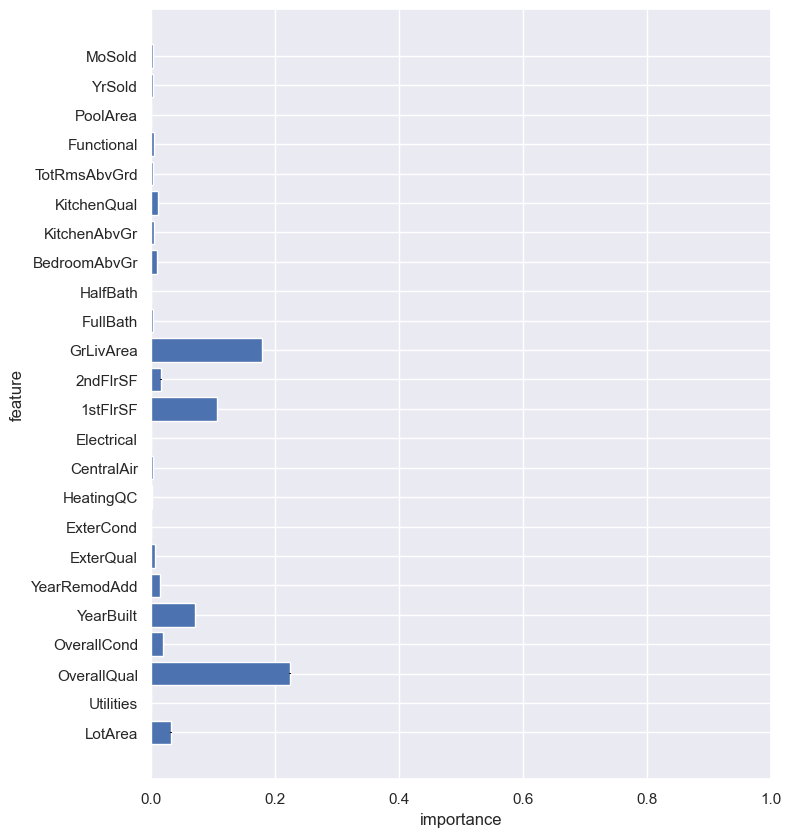

In [101]:
p_importances = permutation_importance(model, x_test, y_test, n_repeats=10, n_jobs=-1)

plt.figure(figsize=(8, 10))
plt.barh(list(df_x.columns),
        p_importances.importances_mean,
        yerr=p_importances.importances_std, )
plt.ylabel('feature')
plt.xlabel('importance')
plt.xlim(0, 1);